## Import all the necessary libraries

In [1]:
import os
import operator
from os import listdir
from os.path import isfile, join, isdir
import itertools
import numpy as np
import pandas as pd
import glob
from functools import reduce
import seaborn as sns
sns.set(color_codes=True)

from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Classification Rate/Accuracy:
# Accuracy = (TP + TN) / (TP + TN + FP + FN)

# Recall: Recall gives us an idea about when it’s actually yes, how often does it predict yes.
# Recall=TP / (TP + FN)

# Precision: Precsion tells us about when it predicts yes, how often is it correct.
# Precision = TP / (TP + FP)

# F-measure:
# Fmeasure=(2*Recall*Precision)/(Recall+Presision)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
np.random.seed(0)

## Get all the data.tsv from the directory

In [63]:
def get_list_of_tables_from_folder(path_to_directory):
    #list the files
#     path_to_directory = "/Users/safamahbub/Desktop/NHAHES5"
    count_files = [(path_to_directory + "/" + f ) for f in listdir(path_to_directory) if isdir(join(path_to_directory, f))]

    for folder in range(len(count_files)):
        count_files[folder] = [(count_files[folder] + "/" + f) for f in listdir(count_files[folder]) if isdir(join(count_files[folder], f))][0]
        count_files[folder] = [(count_files[folder] + "/" + f ) for f in listdir(count_files[folder]) if (isfile(join(count_files[folder], f)) and os.path.splitext(f)[1] == ".tsv" )][0]

    #read them into pandas
    df_list = [pd.read_table(file) for file in count_files]
    for i in range(len(df_list)):
        df_list[i].name = count_files[i].split("/")[5]
    return df_list

df_list = get_list_of_tables_from_folder("/Users/safamahbub/Desktop/NHAHES2007-2008")
df_list2 = get_list_of_tables_from_folder("/Users/safamahbub/Desktop/NHAHES2005-2006")



IndexError: list index out of range

In [3]:
# df_list2

# Methods to help us clean out the dataset

In [4]:
def print_list_of_df(list_of_df):        
    for i in range(len(list_of_df)):
        print(list_of_df[i].name)
        
def delete_empty_row(df):
    list_to_delete = []
    for i in range(df.shape[0]):
        sum = 0
        for column in df.columns:
            if df.iloc[i][column] == " ": sum = sum + 1
        if sum == (df.shape[1] - 1 ): list_to_delete.append(i)
    df = df.drop(list_to_delete, axis=0)
    return df

def delete_empty_columns(df):
    list_to_delete = []
    for column in df.columns:
        sum = 0
        for i in range(df.shape[0]):
            if df.iloc[i][column] == " ": sum = sum + 1
        if sum >= (df.shape[0] - 1 )/3: list_to_delete.append(column)
    df = df.drop(list_to_delete, axis=1)
    return df

def delete_empty_columns_list(df):
    list_to_delete = []
    for column in df.columns:
        sum = 0
        for i in range(df.shape[0]):
            if df.iloc[i][column] == " ": sum = sum + 1
        if sum >= (df.shape[0] - 1 )/4: list_to_delete.append(column)
    return list_to_delete

def split_df(df,target='OSQ060', split_value=1):
    has = df.loc[df[target] == 1]
    has_shape = has.shape
    doesnt_have = df.loc[df[target] == 2]
    doesnt_have = doesnt_have.sample(has_shape[0] * split_value)
    result = has.append(doesnt_have, ignore_index=True, sort=False)
    return result

def pipe_df(list_of_dfs, filter_func):
    transformed_df_list = transform_dfs(list_of_dfs)
    list_filtered = filter_df(transformed_df_list, filter_func)
    df = merge_df(list_filtered)
    df = split_df(df)
    return df

def get_certain_dfs(df):
    if df.name ==  "DS102 Laboratory Complete Blood Count With 5-Part Differential in Whole Blood": return True
    if df.name == "DS1 Demographics" : return True
    if df.name == "DS219 Questionnaire Osteoporosis": return True
    return False

## Discard the DEMO info found in all the tables

In [5]:
def get_unique_features(df, common_values=[u'SDDSRVYR', u'RIDSTATR', u'RIDEXMON', u'RIAGENDR', u'RIDAGEYR',
       u'RIDAGEMN', u'RIDAGEEX', u'RIDRETH1', u'DMQMILIT', u'DMDBORN2',
       u'DMDCITZN', u'DMDYRSUS', u'DMDEDUC3', u'DMDEDUC2', u'DMDSCHOL',
       u'DMDMARTL', u'DMDHHSIZ', u'DMDFMSIZ', u'INDHHIN2', u'INDFMIN2',
       u'INDFMPIR', u'RIDEXPRG', u'DMDHRGND', u'DMDHRAGE', u'DMDHRBR2',
       u'DMDHREDU', u'DMDHRMAR', u'DMDHSEDU', u'SIALANG', u'SIAPROXY',
       u'SIAINTRP', u'FIALANG', u'FIAPROXY', u'FIAINTRP', u'MIALANG',
       u'MIAPROXY', u'MIAINTRP', u'AIALANG', u'WTINT2YR', u'WTMEC2YR',
       u'SDMVPSU', u'SDMVSTRA']):
    if df.name == "DS1 Demographics":
        df_return = df
        df_return.name = df.name
        return df_return
    unique_features = np.setdiff1d(df.columns,common_values, assume_unique=True)
    new_df = df[unique_features]
    new_df.name = df.name
    return new_df

#       ['INDHHIN2' 'INDFMIN2' 'DMDHRBR2']
# DMDBORN INDHHINC INDFMINC DMDHRBRN
def get_unique_features2(df, common_values=[u'SDDSRVYR', u'RIDSTATR', u'RIDEXMON', u'RIAGENDR', u'RIDAGEYR',
       u'RIDAGEMN', u'RIDAGEEX', u'RIDRETH1', u'DMQMILIT', u'DMDBORN',
       u'DMDCITZN', u'DMDYRSUS', u'DMDEDUC3', u'DMDEDUC2', u'DMDSCHOL',
       u'DMDMARTL', u'DMDHHSIZ', u'DMDFMSIZ', u'INDHHINC', u'INDFMINC',
       u'INDFMPIR', u'RIDEXPRG', u'DMDHRGND', u'DMDHRAGE', u'DMDHRBRN',
       u'DMDHREDU', u'DMDHRMAR', u'DMDHSEDU', u'SIALANG', u'SIAPROXY',
       u'SIAINTRP', u'FIALANG', u'FIAPROXY', u'FIAINTRP', u'MIALANG',
       u'MIAPROXY', u'MIAINTRP', u'AIALANG', u'WTINT2YR', u'WTMEC2YR',
       u'SDMVPSU', u'SDMVSTRA']):
    if df.name == "DS1 Demographics":
        df_return = df
        df_return.name = df.name
        return df_return
    unique_features = np.setdiff1d(df.columns,common_values, assume_unique=True)
    new_df = df[unique_features]
    new_df.name = df.name
    return new_df

def unique_dfs(df_list):
    df_unique = [get_unique_features(df) for df in df_list]
    df_newList = []
    number = 0
    for df in df_unique:
        adding_df = df_unique[number]
        adding_df.name = df_unique[number].name
        df_newList.append(adding_df)
        number = number + 1
    return df_newList

def unique_dfs2(df_list):
    df_unique = [get_unique_features2(df) for df in df_list]
    df_newList = []
    number = 0
    for df in df_unique:
        adding_df = df_unique[number]
        adding_df.name = df_unique[number].name
        df_newList.append(adding_df)
        number = number + 1
    return df_newList

In [6]:
df_unique = unique_dfs(df_list)
df_unique2 = unique_dfs2(df_list2)
# df_unique
# df_unique2

## Change the data from String values to Numeric Values

In [7]:
def get_rid_of_0(df):
    name = df.name
    changed_df = df.replace(" ", -1)
    changed_df.name = name
    return changed_df

def change_to_numeric(df):
    name = df.name
    changed_df = df.apply(pd.to_numeric)
    changed_df = changed_df[changed_df[changed_df.columns] >= 0]
    changed_df.name = name
    return changed_df

def no_zero_and_converted_value(df):
    name = df.name
    changed_df = get_rid_of_0(df)
    changed_df = change_to_numeric(changed_df)
    changed_df.name = name
    return changed_df

In [8]:
converted_df = [no_zero_and_converted_value(df) for df in df_unique]
converted_df2 = [no_zero_and_converted_value(df) for df in df_unique2]
# converted_df
# converted_df2x

In [9]:
# converted_df

In [10]:
feature_dict = {
    "SEQN": "Respondent sequence number",
    "LBXCRP": "C-reactive protein(mg/dL)",
    "URXUIO": "Iodine, urine (ug/L)",
    "LBXTC": "Total Cholesterol (mg/dL)",
    "LBXBCD": "Blood cadmium (ug/L)",
    "LBXBPB": "Blood lead (ug/dL)",
    "URXUMS": "Albumin, urine (mg/L)",
    "URXUCR": "Creatinine, urine (mg/dL)",
    "LBXGH": "Glycohemoglobin (%)",
    "RIAGENDR": "Gender",
    "RIDAGEYR": "Age at Screening Adjudicated - Recode",
    "RIDRETH1": "Race/Ethnicity - Recode",
    "DMDBORN2": "Country of Birth - Recode",
    "WTINT2YR": "Full Sample 2 Year Interview Weight",
    "WTMEC2YR": "Full Sample 2 Year MEC Exam Weight",
    "SDMVPSU": "Masked Variance Pseudo-PSU",
    "SDMVSTRA": "Masked Variance Pseudo-Stratum",
    "LBXWBCSI": "White blood cell count (1000 cells/uL)",
    "LBXLYPCT": "Lymphocyte percent (%)",
    "LBXMOPCT": "Monocyte percent (%)",
    "LBXNEPCT": "Segmented neutrophils percent (%)",
    "LBXEOPCT": "Eosinophils percent (%)",
    "LBXBAPCT": "Basophils percent (%)",
    "LBDLYMNO": "Lymphocyte number (1000 cells/uL)",
    "LBDMONO": "Monocyte number (1000 cells/uL)",
    "LBDNENO": "Segmented neutrophils num (1000 cell/uL)",
    "LBDEONO": "Eosinophils number (1000 cells/uL)",
    "LBDBANO": "Basophils number (1000 cells/uL)",
    "LBXRBCSI": "Red blood cell count (million cells/uL)",
    "LBXHGB": "Hemoglobin (g/dL)",
    "LBXHCT": "Hematocrit (%",
    "LBXMCVSI": "Mean cell volume (fL)",
    "LBXMCHSI": "Mean cell hemoglobin (pg)",
    "LBXMC": "MCHC (g/dL)",
    "LBXRDW": "Red cell distribution width (%)",
    "LBXPLTSI": "Platelet count (1000 cells/uL)",
    "LBXMPSI": "Mean platelet volume (fL)",
    "PEASCST1": "Blood Pressure Status", #only need if 1???????
    "PEASCTM1": "Blood Pressure Time in Seconds",
    "BPQ150A": "Had food in the past 30 minutes?",
    "BPQ150B": "Had alcohol in the past 30 minutes?",
    "BPQ150C": "Had coffee in the past 30 minutes?",
    "BPQ150D": "Had cigarettes in the past 30 minutes?",
    "BPXPLS": "60 sec. pulse (30 sec. pulse * 2):",
    "BPXPULS": "Pulse regular or irregular?",
    "BPXPTY": "Pulse type:",
    "BPXML1": "MIL: maximum inflation levels (mm Hg)",
    "BPXSY1": "Systolic: Blood pres (1st rdg) mm Hg",
    "BPXDI1": "Diastolic: Blood pres (1st rdg) mm Hg",
    "BPXSY2": "Systolic: Blood pres (2nd rdg) mm Hg",
    "BPXDI2": "Diastolic: Blood pres (2nd rdg) mm Hg",
    "BPXSY3": "Diastolic: Blood pres (3rd rdg) mm Hg",
    "BPXDI3": "Diastolic: Blood pres (3rd rdg) mm Hg",
    "LBXSAL": "Albumin (g/dL)",
    "LBDSALSI": "Albumin (g/L)",
    "LBXSATSI": "Alanine aminotransferase (ALT) (U/L)",
    "LBXSASSI": "Asparate aminotransferase (AST) (U/L)",
    "LBXSBU": "Blood urea nitrogen (mg/dL)",
    "LBDSBUSI": "Blood urea nitrogen (mmol/L)",#duplicate
    "LBXSCH": "Cholesterol (mg/dL)", #same as LBXTC???
    "LBDSCHSI": "Cholesterol (mmol/L)",#same as LBXTC???
    "LBXSC3SI": "Bicarbonate (mmol/L)",
    "LBXSGTSI": "Gamma glutamyl transferase (U/L)",
    "LBXSGL": "Glucose, serum (mg/dL)",
    "LBDSGLSI": "Glucose, serum (mmol/L)",#duplicate
    "LBXSIR": "Iron, refigerated (ug/dL)",
    "LBDSIRSI": "Iron, refigerated (umol/L)",#duplicate
    "LBXSLDSI": "Lactate dehydrogenase LDH (U/L)",
    "LBXSPH": "Phosphorus (mg/dL)",
    "LBDSPHSI": "Phosphorus (mmol/L)",#duplicate
    "LBXSTB": "Total bilirubin (mg/dL)",
    "LBDSTBSI": "Bilirubin, total (umol/L)",#duplicate
    "LBXSTP": "Total protein (g/dL)",
    "LBDSTPSI": "Total protein (g/L)",#duplicate
    "LBXSTR": "Triglycerides (mg/dL)",
    "LBDSTRSI": "Triglycerides (mmol/L)",#duplicate
    "LBXSUA": "Uric acid (mg/dL)",
    "LBDSUASI": "Uric acid (umol/L)",#duplicate
    "LBXSKSI": "Potassium (mmol/L)",
    "LBXSCLSI": "Chloride (mmol/L)",
    "LBXSOSSI": "Osmolality (mmol/Kg)",
    "LBXSGB": "Globulin (g/dL)",
    "LBDSGBSI": "Globulin (g/L)",#duplicate
    "BMXWT": "Weight (kg)",
    "BMXHT": "Standing Height (cm)",
    "BMXBMI": "Body Mass Index (kg/m**2)",
    "BMXLEG": "Upper Leg Length (cm)",
    "BMXARML": "Upper Arm Length (cm)",
    "BMXARMC": "Arm Circumference (cm)",
    "BMXWAIST": "Waist Circumference (cm)",
    "BMXTRI": "Triceps Skinfold (mm)",
    "BMXSUB": "Subscapular Skinfold (mm)",
    "LBXTHG": "Mercury, total (ug/L)",
    "LBXIHG": "Mercury, inorganic (ug/L)",
    "LBDTHGLC": "Mercury, total comment code" #don't need
}

BMD_library = {
    "OSQ060": "Ever told had osteoporosis/brittle bones",
    "DXXFMBCC": "Total femur BMD invalidity code",
    "DXXOFBMD": "Total femur BMD",
    'DXXOFBMC': "Total femur BMC",
    'DXXOFA': "Total femur area",
    'DXXNKBMD': "Femoral neck BMD",
    'DXXNKBMC': "Femoral neck BMC",
    'DXXNKA': "Femoral neck area",
    'DXXTRBMD': "Trochanter BMD",
    'DXXTRBMC': "Trochanter BMC",
    'DXXTRA': "Trochanter area",
    'DXXINBMD': "Intertrochanter BMD",
    'DXXINBMC': "Intertrochanter BMC",
    'DXXINA': "Intertrochanter area",
    'DXXWDBMD': "Ward's triangle BMD",
    'DXXWDBMC': "Ward's triangle BMC",
    'DXXWDA': "Ward's triangle area",
    'DXAFMRK': "Calculated K for femur",
    'DXAFMRD0': "Calculated DO for femur"
	}
BMD_filter_out = list(BMD_library)
print(BMD_filter_out)

BMD_library_check = {
    "OSQ060": "Ever told had osteoporosis/brittle bones",
    "DXXOFBMD": "Total femur BMD",
    'DXXNKBMD': "Femoral neck BMD",
    'DXXTRBMD': "Trochanter BMD",
    'DXXINBMD': "Intertrochanter BMD",
    'DXXWDBMD': "Ward's triangle BMD",
    'DXAFMRK': "Calculated K for femur",
    'DXAFMRD0': "Calculated DO for femur"
	}
BMD_feature_list = list(BMD_library_check)
print(BMD_feature_list)

['DXXNKA', 'DXXINBMC', 'DXXWDBMD', 'DXAFMRD0', 'DXXINA', 'DXXWDBMC', 'DXXINBMD', 'DXXTRA', 'DXXOFA', 'DXXOFBMC', 'DXXOFBMD', 'DXXNKBMC', 'DXXTRBMC', 'DXAFMRK', 'DXXNKBMD', 'DXXTRBMD', 'DXXWDA', 'OSQ060', 'DXXFMBCC']
['DXXWDBMD', 'DXAFMRK', 'DXAFMRD0', 'DXXINBMD', 'DXXTRBMD', 'OSQ060', 'DXXNKBMD', 'DXXOFBMD']


## Transform Dataframes
## Discard columns that are redunant or have a lot of missing values

In [11]:
def transform_dataFrame(df,vers=0):
    dataframe_name = df.name
    if dataframe_name == "DS11 Examination Blood Pressure":
        #Keep if the Blood Pressure Status is Complete
        df = df[df.PEASCST1 ==1]
        df = df.drop(['PEASCCT1'], axis=1)
        df = df.drop(['PEASCST1'], axis=1)
        
        #drop because redundant information
        df = df.drop(['BPAARM','BPACSZ','BPAEN1','BPAEN2', 'BPAEN3', 'BPAEN4'], axis=1)
        #df = df.drop(['BPQ150A', 'BPQ150B', 'BPQ150C', 'BPQ150D'], axis=1)
        
        #drop because Range of value and too much are missing
        df = df.drop(['BPXCHR'], axis=1)
        
        #Systolic blood pressure (the first number) – indicates how much pressure your blood is exerting against your artery walls when the heart beats.
        #Diastolic blood pressure (the second number) – indicates how much pressure your blood is exerting against your artery walls while the heart is resting between beats.
        #120/80  Systolic/Diastolic
        #drop 4th reading because too many missing values
        df = df.drop(['BPXSY4', 'BPXDI4'], axis=1)
        
        #Systolic blood pressure (the first number) – indicates how much pressure your blood is exerting against your artery walls when the heart beats.
        #Diastolic blood pressure (the second number) – indicates how much pressure your blood is exerting against your artery walls while the heart is resting between beats.
        #120/80  Systolic/Diastolic
        #drop 4th reading because too many missing values
        # Normal Systolic is 90-120 based on https://www.healthline.com/health/high-blood-pressure-hypertension/blood-pressure-reading-explained
        df = df[df['BPXSY1'].between(90, 170, inclusive=True)]
        df = df[df['BPXSY2'].between(90, 170, inclusive=True)]
        df = df[df['BPXSY3'].between(90, 170, inclusive=True)]
        df['AverageSY'] = (df['BPXSY1'] + df['BPXSY2'] + df['BPXSY3'])/3
        df = df.drop(['BPXSY1','BPXSY2', 'BPXSY3'], axis=1)
        #Normal Distolic is 60-80 based on https://www.healthline.com/health/high-blood-pressure-hypertension/blood-pressure-reading-explained
        df = df[df['BPXDI1'].between(0, 116, inclusive=True)]
        df = df[df['BPXDI2'].between(0, 122, inclusive=True)]
        df = df[df['BPXDI3'].between(0, 120, inclusive=True)]
        df['AverageDI'] = (df['BPXDI1'] + df['BPXDI2'] + df['BPXDI3'])/3
        df = df.drop(['BPXDI1','BPXDI2', 'BPXDI3'], axis=1)
        
        
        #Maybe replace with the average not with 0
        #Had food, alcohol, coffe, or cigarets in the last 30 minutes
        #Only valuse of 1 (yes), 2(no), or missing so instead replace missing with 0
        df[['BPQ150A', 'BPQ150B', 'BPQ150C', 'BPQ150D']] = df[['BPQ150A', 'BPQ150B', 'BPQ150C', 'BPQ150D']].replace(' ', 0, regex=True)
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS12 Examination Body Measurements":
        #only keep data values that are complete
        df = df[df.BMDSTATS ==1]
        df = df.drop(['BMDSTATS'], axis=1)
        
        #drop because too much missing values
        df = df.drop(['BMIWT','BMXRECUM', 'BMIRECUM', 'BMXRECUM', 'BMXHEAD', 'BMIHEAD', 'BMIHT','BMILEG','BMIARML', 'BMIARML', 'BMIARMC', 'BMIWAIST', 'BMITRI', 'BMISUB'], axis=1)
        
#         #Replace " " with 0
#         df[df.columns] = df[df.columns].replace(' ', 0, regex=True)
        
        #Replace " " with average
        df[df.columns] = df[df.columns].replace(' ', np.nan, regex=True)
        df = df.fillna(df.mean()).dropna(axis=1, how='all')
        
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS13 Examination Dual Energy Xray Absorptiometry Femur":
    #DON'T USE THIS TABLE: may manipulate data wrongly
        df = df[df.DXAFMRST ==1]
        df = df.drop(['DXAFMRST'], axis=1)
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS100 Laboratory Blood Cadmium and Lead":
    #Data is given as (ug/L) and (nmol/L) so we will use one
        #Use (ug/L) so drop the (nmol/L)
        df = df.drop(['LBDBCDSI','LBDBPBSI'], axis=1)
        #Use (nmol/L) so drop the (ug/L)
        #df = df.drop(['LBXBCD','LBXBPB'], axis=1)
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS101 Laboratory Blood Total Mercury and Blood Inorganic Mercury":
    #Data is given as (ug/L) and (nmol/L) so we will use one
        #Use (ug/L) so drop the (nmol/L)
        df = df.drop(['LBDTHGSI','LBDIHGSI'], axis=1)
        #Use (nmol/L) so drop the (ug/L)
        #df = df.drop(['LBXTHG','LBXIHG'], axis=1)
        df = df.drop(['LBDTHGLC'], axis=1) #don't need, a murcury comment code 
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS102 Laboratory Complete Blood Count With 5-Part Differential in Whole Blood":
    #A basic Blood report
        df = df.replace(r'^\s+$', np.nan, regex=True)
        df = df.dropna()
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS103 Laboratory C-Reactive Protein":
    #Only has one feature
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS106 Laboratory Glycohemoglobin":
    #Only has one feature
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS116 Laboratory Standard Biochemistry Profile":
        df = delete_empty_row(df)
        df = df.drop(['LBDSBUSI'], axis=1) #duplicate of LBXSBU
        df = df.drop(['LBXSCH'], axis=1) #duplicate of LBXTC
        df = df.drop(['LBDSCHSI'], axis=1) #duplicate of LBXTC
        df = df.drop(['LBDSGLSI'], axis=1) #duplicate of LBXSGL
        df = df.drop(['LBDSIRSI'], axis=1) #duplicate of LBXSIR
        df = df.drop(['LBDSPHSI'], axis=1) #duplicate of LBXSPH
        df = df.drop(['LBDSTBSI'], axis=1) #duplicate of LBXSTB
        df = df.drop(['LBDSTPSI'], axis=1) #duplicate of LBXSTP
        df = df.drop(['LBDSTRSI'], axis=1) #duplicate of LBXSTR
        df = df.drop(['LBDSUASI'], axis=1) #duplicate of LBXSUA
        df = df.drop(['LBDSGBSI'], axis=1) #duplicate of LBXSGB
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS118 Laboratory Total Cholesterol":
    #Has 1 feature Total Cholesterol
    #Data is given as (mg/dL) and (nmol/L) so we will use one
        #Use (mg/dL) so drop the (nmol/L)
        df = df.drop(['LBDTCSI'], axis=1)
        #Use (nmol/L) so drop the (mg/dL)
        #df = df.drop(['LBXTC'], axis=1)
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS121 Laboratory Urinary Albumin and Urinary Creatinine":
    #Has 2 features Albumin and Creatinine in Urine

        #Albumin Data is given as (ug/mL) and (mg/L)
        #Use (ug/mL) so drop the (mg/L)
        #df = df.drop(['URXUMS'], axis=1)
        #Use (mg/L) so drop the (ug/mL)
        df = df.drop(['URXUMA'], axis=1)
        
        
        #Creatinine is given as (mg/dL) and (umol/L)
        #Use (mg/dL) so drop the (nmol/L)
        df = df.drop(['URXCRS'], axis=1)
        #Use (nmol/L) so drop the (mg/dL)
        #df = df.drop(['URXUCR'], axis=1)
        
        df.name = dataframe_name
        return df 
    elif dataframe_name == "DS123 Laboratory Urinary Iodine":
    #Has 2 features Iodine and Creatinine in Urine        
        #Drop Creatinine because it is given in "DS121 Laboratory Urinary Albumin and Urinary Creatinine"
        df = df.drop(['URXUCR'], axis=1)
        df.name = dataframe_name
        return df 
#     if dataframe_name == "DS219 Questionnaire Osteoporosis":
# #         df = df.drop(['OSQ120J','OSQ180','OSQ190','OSQ210','OSQ220'], axis=1)
#         df = df.drop(['OSQ020A', 'OSQ020B', 'OSQ020C', 'OSD030AA', 'OSQ040AA', 'OSD050AA', 'OSD030AB', 'OSQ040AB', 'OSD050AB', 'OSD030AC', 'OSQ040AC', 'OSD050AC', 'OSD030AD', 'OSQ040AD', 'OSD050AD', 'OSD030AE', 'OSQ040AE', 'OSD050AE', 'OSD030BA', 'OSQ040BA', 'OSD050BA', 'OSD030BB', 'OSQ040BB', 'OSD050BB', 'OSD030BC', 'OSQ040BC', 'OSD050BC', 'OSD030BD', 'OSQ040BD', 'OSD030BE', 'OSQ040BE', 'OSD030BF', 'OSQ040BF', 'OSD030BG', 'OSQ040BG', 'OSD030CA', 'OSQ040CA', 'OSD050CA', 'OSD030CB', 'OSQ040CB', 'OSD050CB', 'OSD030CC', 'OSQ040CC', 'OSD050CC', 'OSD030CD', 'OSQ040CD', 'OSD050CD', 'OSD030CE', 'OSQ040CE', 'OSD050CE', 'OSQ090A', 'OSQ100A', 'OSD110A', 'OSQ120A', 'OSQ090B', 'OSQ100B', 'OSD110B', 'OSQ120B', 'OSQ090C', 'OSQ100C', 'OSD110C', 'OSQ120C', 'OSQ090D', 'OSQ100D', 'OSD110D', 'OSQ120D', 'OSQ090E', 'OSQ100E', 'OSD110E', 'OSQ120E', 'OSQ090F', 'OSQ100F', 'OSD110F', 'OSQ120F', 'OSQ090G', 'OSQ100G', 'OSD110G', 'OSQ120G', 'OSQ090H', 'OSQ100H', 'OSD110H', 'OSQ120H', 'OSQ090I', 'OSQ120I', 'OSQ090J', 'OSQ120J', 'OSQ070', 'OSQ140Q', 'OSQ140U', 'OSQ160A', 'OSQ160B', 'OSQ180', 'OSQ190', 'OSQ210', 'OSQ220'],axis=1)
# #         df = delete_empty_columns(df)
#         df.name = dataframe_name
#         return df
    elif dataframe_name == "DS219 Questionnaire Osteoporosis":
        df = df[['SEQN','OSQ060']]
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS1 Demographics":
        if vers == 1:
            df = df.drop(['SDDSRVYR','RIDSTATR','RIDEXMON','RIDAGEMN','RIDAGEEX','DMQMILIT','DMDCITZN','DMDYRSUS','DMDEDUC3','DMDEDUC2','DMDSCHOL','DMDMARTL','DMDHHSIZ','DMDFMSIZ','INDHHINC','INDFMINC','INDFMPIR','RIDEXPRG','DMDHRGND','DMDHRAGE','DMDHRBRN','DMDHREDU','DMDHRMAR','DMDHSEDU','SIALANG','SIAPROXY','SIAINTRP','FIALANG','FIAPROXY','FIAINTRP','MIALANG','MIAPROXY','MIAINTRP','AIALANG'], axis=1)
        else: 
            df = df.drop(['SDDSRVYR','RIDSTATR','RIDEXMON','RIDAGEMN','RIDAGEEX','DMQMILIT','DMDCITZN','DMDYRSUS','DMDEDUC3','DMDEDUC2','DMDSCHOL','DMDMARTL','DMDHHSIZ','DMDFMSIZ','INDHHIN2','INDFMIN2','INDFMPIR','RIDEXPRG','DMDHRGND','DMDHRAGE','DMDHRBR2','DMDHREDU','DMDHRMAR','DMDHSEDU','SIALANG','SIAPROXY','SIAINTRP','FIALANG','FIAPROXY','FIAINTRP','MIALANG','MIAPROXY','MIAINTRP','AIALANG'], axis=1)
        df = df.dropna()
        df.name = dataframe_name
        return df
    #Catch all Case
    #"DS100 Laboratory Blood Cadmium and Lead"
    else:
        df[df.columns] = df[df.columns].replace(' ', np.nan, regex=True)
        df = df.fillna(df.mean()).dropna(axis=1, how='all')
        df.name = dataframe_name
        return df

def transform_dfs(df_newList):
    df_test_transformed_list = [transform_dataFrame(df) for df in df_newList] 
    return df_test_transformed_list

In [12]:
# Percentage Range got from https://cllsociety.org/toolbox/normal-lab-values/ and https://globalrph.com/laboratory-values/
def transform_dataFrame_to_normal_range(df, vers=0):
    dataframe_name = df.name
    if dataframe_name == "DS11 Examination Blood Pressure":
        #Keep if the Blood Pressure Status is Complete
        df = df[df.PEASCST1 ==1]
        df = df.drop(['PEASCCT1'], axis=1)
        df = df.drop(['PEASCST1'], axis=1)
        
        #drop because redundant information
        df = df.drop(['BPAARM','BPACSZ','BPAEN1','BPAEN2', 'BPAEN3', 'BPAEN4'], axis=1)
        df = df.drop(['BPQ150A', 'BPQ150B', 'BPQ150C', 'BPQ150D'], axis=1)
        df = df[df['BPXPLS'].between(40, 224, inclusive=True)]
        df = df[df['BPXML1'].between(110, 200, inclusive=True)]
        
        #drop because Range of value and too much are missing
        df = df.drop(['BPXCHR'], axis=1)
        
        #Systolic blood pressure (the first number) – indicates how much pressure your blood is exerting against your artery walls when the heart beats.
        #Diastolic blood pressure (the second number) – indicates how much pressure your blood is exerting against your artery walls while the heart is resting between beats.
        #120/80  Systolic/Diastolic
        #drop 4th reading because too many missing values
        df = df.drop(['BPXSY4', 'BPXDI4'], axis=1)
        # Normal Systolic is 90-120 based on https://www.healthline.com/health/high-blood-pressure-hypertension/blood-pressure-reading-explained
        df = df[df['BPXSY1'].between(90, 170, inclusive=True)]
        df = df[df['BPXSY2'].between(90, 170, inclusive=True)]
        df = df[df['BPXSY3'].between(90, 170, inclusive=True)]
        df['AverageSY'] = (df['BPXSY1'] + df['BPXSY2'] + df['BPXSY3'])/3
        df = df.drop(['BPXSY1','BPXSY2', 'BPXSY3'], axis=1)
        #Normal Distolic is 60-80 based on https://www.healthline.com/health/high-blood-pressure-hypertension/blood-pressure-reading-explained
        df = df[df['BPXDI1'].between(0, 116, inclusive=True)]
        df = df[df['BPXDI2'].between(0, 122, inclusive=True)]
        df = df[df['BPXDI3'].between(0, 120, inclusive=True)]
        df['AverageDI'] = (df['BPXDI1'] + df['BPXDI2'] + df['BPXDI3'])/3
        df = df.drop(['BPXDI1','BPXDI2', 'BPXDI3'], axis=1)
        
        #Maybe replace with the average not with 0
        #Had food, alcohol, coffe, or cigarets in the last 30 minutes
        #Only valuse of 1 (yes), 2(no), or missing so instead replace missing with 0
        #df[['BPQ150A', 'BPQ150B', 'BPQ150C', 'BPQ150D']] = df[['BPQ150A', 'BPQ150B', 'BPQ150C', 'BPQ150D']].replace(' ', 0, regex=True)
        df = df[df[df.columns] >= 0]
        df = df.dropna()
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS12 Examination Body Measurements":
        #only keep data values that are complete
        df = df[df.BMDSTATS ==1]
        df = df.drop(['BMDSTATS'], axis=1)
        #df = df[df[''].between(, , inclusive=True)]
        df = df[df['BMXWT'].between(30, 105, inclusive=True)]
        df = df[df['BMXHT'].between(81.5, 203.8, inclusive=True)]
        df = df[df['BMXBMI'].between(12.5, 40, inclusive=True)]
        df = df[df['BMXLEG'].between(27, 45, inclusive=True)]
        df = df[df['BMXARML'].between(9, 47.7, inclusive=True)]
        df = df[df['BMXARMC'].between(9.6, 40, inclusive=True)]
        df = df[df['BMXWAIST'].between(37.8, 178.2, inclusive=True)]
        df = df[df['BMXTRI'].between(3, 41.4, inclusive=True)]
        df = df[df['BMXSUB'].between(3, 44, inclusive=True)]
        
        #drop because too much missing values
        df = df.drop(['BMIWT','BMXRECUM', 'BMIRECUM', 'BMXRECUM', 'BMXHEAD', 'BMIHEAD', 'BMIHT','BMILEG','BMIARML', 'BMIARML', 'BMIARMC', 'BMIWAIST', 'BMITRI', 'BMISUB'], axis=1)
        
#         #Replace " " with 0
#         df[df.columns] = df[df.columns].replace(' ', 0, regex=True)
        
        #Replace " " with average
        df = df[df[df.columns] >= 0]
        df[df.columns] = df[df.columns].replace(' ', np.nan, regex=True)
        df = df.fillna(df.mean()).dropna(axis=1, how='all')
        
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS13 Examination Dual Energy Xray Absorptiometry Femur":
    #DON'T USE THIS TABLE: may manipulate data wrongly
        df = df[df.DXAFMRST ==1]
        df = df.drop(['DXAFMRST'], axis=1)
        df = df[df.DXXFMBCC ==0]
        df = df.drop(['DXXFMBCC'], axis=1)
        df = df[df['DXXOFBMD'].between(0.419, 1.579, inclusive=True)]
        df = df[df['DXXOFBMC'].between(5.88, 74.27, inclusive=True)]
        df = df[df['DXXOFA'].between(12.2, 59.6, inclusive=True)]
        df = df[df['DXXNKBMD'].between(0.34, 1.487, inclusive=True)]
        df = df[df['DXXNKBMC'].between(1.46, 8.59, inclusive=True)]
        df = df[df['DXXNKA'].between(2.85, 7.38, inclusive=True)]
        df = df[df['DXXTRBMD'].between(0.303, 1.25, inclusive=True)]
        df = df[df['DXXTRBMC'].between(0.86, 20.57, inclusive=True)]
        df = df[df['DXXTRA'].between(2.15, 21.47, inclusive=True)]
        df = df[df['DXXINBMD'].between(0.487, 1.875, inclusive=True)]
        df = df[df['DXXINBMC'].between(3.45, 51.46, inclusive=True)]
        df = df[df['DXXINA'].between(6.76, 35.69, inclusive=True)]
        df = df[df['DXXWDBMD'].between(0.11, 1.786, inclusive=True)]
        df = df[df['DXXWDBMC'].between(0.13, 1.85, inclusive=True)]
        df = df[df['DXXWDA'].between(1.04, 1.31, inclusive=True)]
        df = df[df['DXAFMRK'].between(1.1139, 1.1544, inclusive=True)]
        df = df[df['DXAFMRD0'].between(40.504, 63.0186, inclusive=True)]
        df = df[df[df.columns] >= 0]
        df = df.dropna()
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS100 Laboratory Blood Cadmium and Lead":
    #Data is given as (ug/L) and (nmol/L) so we will use one
        #Use (ug/L) so drop the (nmol/L)
        df = df.drop(['LBDBCDSI','LBDBPBSI'], axis=1)
        #Use (nmol/L) so drop the (ug/L)
        #df = df.drop(['LBXBCD','LBXBPB'], axis=1)
        df = df[df[df.columns] >= 0]
        df = df.dropna()
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS101 Laboratory Blood Total Mercury and Blood Inorganic Mercury":
    #Data is given as (ug/L) and (nmol/L) so we will use one
        #Use (ug/L) so drop the (nmol/L)
        df = df.drop(['LBDTHGSI','LBDIHGSI'], axis=1)
        #Use (nmol/L) so drop the (ug/L)
        #df = df.drop(['LBXTHG','LBXIHG'], axis=1)
        df = df[df['LBXTHG'].between(0, 10, inclusive=True)]
        df = df.drop(['LBDTHGLC'], axis=1) #don't need, a murcury comment code 
        df = df[df[df.columns] >= 0]
        df = df.dropna()
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS102 Laboratory Complete Blood Count With 5-Part Differential in Whole Blood":
    #A basic Blood report
        # Percentage Range got from https://cllsociety.org/toolbox/normal-lab-values/
        df = df[df['LBXLYPCT'].between(4.9, 85.5, inclusive=True)] # Normal Lymphocyte percent (%) Range Value 20% to 40%
        df = df[df['LBXMOPCT'].between(0.7, 44.5, inclusive=True)] # Normal Monocyte percent (%) Range Value 2% to 8%
        df = df[df['LBXNEPCT'].between(5.3, 92.1, inclusive=True)] # Normal Neutrophils percent (%) Range Value 40% to 60%
        df = df[df['LBXEOPCT'].between(0, 28.5, inclusive=True)] # Normal Eosinophils percent (%) Range Value 1% to 4%
        df = df[df['LBXBAPCT'].between(0, 2, inclusive=True)] # Normal Basophils percent (%) Range Value 0.5% to 1%
        df = df[df['LBDLYMNO'].between(0.4, 5, inclusive=True)]
        df = df[df['LBDMONO'].between(0.1, 5.5, inclusive=True)]
        df = df[df['LBDNENO'].between(0.2, 20.5, inclusive=True)]
        df = df[df['LBDEONO'].between(0, 0.75, inclusive=True)]
        df = df[df['LBDBANO'].between(0, .10, inclusive=True)]
        df = df[df['LBXRBCSI'].between(2.49, 6.97, inclusive=True)] # Normal Red blood cell count (million cells/uL) Range Value Male(4.7 to 6.1) and Female(4.2 to 5.4)
        df = df[df['LBXHGB'].between(10, 18, inclusive=True)] #Normal Hemoglobin (g/dL) Range Value Male(13.8-17.2) and Female(12.1-15.1)
        df = df[df['LBXHCT'].between(22.4, 56.3, inclusive=True)] # Normal Hematocrit Range Value Male(40.7-50.3%) and Female(36.1-44.3%)
        df = df[df['LBXMCVSI'].between(55.9, 105, inclusive=True)] # Normal Mean corpuscular volume (fl) Range Value 80-100 fL
        df = df[df['LBXMCHSI'].between(18, 37, inclusive=True)] # Normal Mean corpuscular hemoglobin (pg) Range Value 27-31 pg
        df = df[df['LBXMC'].between(30, 42.4, inclusive=True)] # Normal Mean corpuscular hemoglobin concentration (g/dL) Range Value 32-36 g/dL
        df = df[df['LBXRDW'].between(6.3, 37.8, inclusive=True)] # Normal Red cell distribution width (%) Range Value Male(11.8-15.6%) and Female(11.9-15.5%)
        df = df[df['LBXPLTSI'].between(28, 1000, inclusive=True)] ####### Normal Number of platelets Range Value 150-450 x 109/L
        df = df[df['LBXMPSI'].between(5.1, 12.6, inclusive=True)] # Normal 

        df = df[df[df.columns] >= 0]
        df = df.replace(r'^\s+$', np.nan, regex=True)
        df = df.dropna()
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS103 Laboratory C-Reactive Protein":
    #Only has one feature
        df = df[df[df.columns] >= 0]
        df = df.dropna()
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS106 Laboratory Glycohemoglobin":
    #Only has one feature
        df = df[df['LBXGH'].between(4, 8, inclusive=True)]
        df = df[df[df.columns] >= 0]
        df = df.dropna()
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS116 Laboratory Standard Biochemistry Profile":
        df = delete_empty_row(df)
        
        df = df[df['LBXSAL'].between(3.5, 5.5, inclusive=True)] # Normal Albumin Range Value 3.5-5.5 g/dL
        df = df.drop(['LBDSALSI'], axis=1) #duplicate of LBXSBU
        df = df[df['LBXSBU'].between(2, 30, inclusive=True)] # Normal Blood urea nitrogen Range Value 6 – 20 mg/dL
        df = df.drop(['LBDSBUSI'], axis=1) #duplicate of LBXSBU
        
        
        df = df.drop(['LBXSCH'], axis=1) #duplicate of LBXTC From DS118 Laboratory Total Cholesterol
        df = df.drop(['LBDSCHSI'], axis=1) #duplicate of LBXTC From DS118 Laboratory Total Cholesterol
        
        df = df[df['LBXSGL'].between(33, 559, inclusive=True)] # Normal Glucose Range Value 80-120 mg/dL
        df = df.drop(['LBDSGLSI'], axis=1) #duplicate of LBXSGL
        df = df[df['LBXSIR'].between(7, 387, inclusive=True)] # Normal Iron Range Value 65 – 150
        df = df.drop(['LBDSIRSI'], axis=1) #duplicate of LBXSIR
        df = df[df['LBXSPH'].between(2.5, 5, inclusive=True)] # Normal Phosphorus (mg/dL) Range Value 
        df = df.drop(['LBDSPHSI'], axis=1) #duplicate of LBXSPH
        df = df[df['LBXSTB'].between(0.1, 1.5, inclusive=True)] # Normal Bilirubin (mg/dL) Range Value 0 - 1.2
        df = df.drop(['LBDSTBSI'], axis=1) #duplicate of LBXSTB
        df = df[df['LBXSTP'].between(6, 8.5, inclusive=True)] # Normal Total protein (g/dL) Range Value 
        df = df.drop(['LBDSTPSI'], axis=1) #duplicate of LBXSTP
        df = df[df['LBXSTR'].between(16, 350, inclusive=True)] # Normal Triglycerides (mg/dL) Range Value <150
        df = df.drop(['LBDSTRSI'], axis=1) #duplicate of LBXSTR
        df = df[df['LBXSUA'].between(2, 9, inclusive=True)] # Normal Uric acid (mg/dL) Range Value Male (2.0-80) and Female(2.0-7.5)
        df = df.drop(['LBDSUASI'], axis=1) #duplicate of LBXSUA
        df = df[df['LBXSGB'].between(1, 6.5, inclusive=True)] # Normal Globulin (g/dL) Range Value 1.5-3.5 g/dL
        df = df.drop(['LBDSGBSI'], axis=1) #duplicate of LBXSGB
        df = df[df['LBXSLDSI'].between(0, 200, inclusive=True)]
        df = df[df['LBXSATSI'].between(0, 50, inclusive=True)]
    
        df = df[df[df.columns] >= 0]
        df = df.dropna()
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS118 Laboratory Total Cholesterol":
    #Has 1 feature Total Cholesterol
    #Data is given as (mg/dL) and (nmol/L) so we will use one
        #Use (mg/dL) so drop the (nmol/L)
        df = df.drop(['LBDTCSI'], axis=1)
        #Use (nmol/L) so drop the (mg/dL)
        #df = df.drop(['LBXTC'], axis=1)
        df = df[df['LBXTC'].between(0, 300, inclusive=True)]
        df = df[df[df.columns] >= 0]
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS121 Laboratory Urinary Albumin and Urinary Creatinine":
    #Has 2 features Albumin and Creatinine in Urine

        #Albumin Data is given as (ug/mL) and (mg/L)
        #Use (ug/mL) so drop the (mg/L)
        #df = df.drop(['URXUMS'], axis=1)
        #Use (mg/L) so drop the (ug/mL)
        df = df.drop(['URXUMA'], axis=1)
        
        
        #Creatinine is given as (mg/dL) and (umol/L)
        #Use (mg/dL) so drop the (nmol/L)
        df = df.drop(['URXCRS'], axis=1)
        #Use (nmol/L) so drop the (mg/dL)
        #df = df.drop(['URXUCR'], axis=1)
        df = df[df['URXUCR'].between(0, 250, inclusive=True)]
        df = df[df[df.columns] >= 0]
        df = df.dropna()
        df.name = dataframe_name
        return df 
    elif dataframe_name == "DS123 Laboratory Urinary Iodine":
    #Has 2 features Iodine and Creatinine in Urine        
        #Drop Creatinine because it is given in "DS121 Laboratory Urinary Albumin and Urinary Creatinine"
        df = df.drop(['URXUCR'], axis=1)
        df = df[df[df.columns] >= 0]
        df = df.dropna()
        df.name = dataframe_name
        return df 
    elif dataframe_name == "DS219 Questionnaire Osteoporosis":
        df = df[['SEQN','OSQ060']]
        df.name = dataframe_name
        return df
    elif dataframe_name == "DS1 Demographics":
        if vers == 1:
            df = df.drop(['SDDSRVYR','RIDSTATR','RIDEXMON','RIDAGEMN','RIDAGEEX','DMQMILIT','DMDCITZN','DMDYRSUS','DMDEDUC3','DMDEDUC2','DMDSCHOL','DMDMARTL','DMDHHSIZ','DMDFMSIZ','INDHHINC','INDFMINC','INDFMPIR','RIDEXPRG','DMDHRGND','DMDHRAGE','DMDHRBRN','DMDHREDU','DMDHRMAR','DMDHSEDU','SIALANG','SIAPROXY','SIAINTRP','FIALANG','FIAPROXY','FIAINTRP','MIALANG','MIAPROXY','MIAINTRP','AIALANG'], axis=1)
        else: 
            df = df.drop(['SDDSRVYR','RIDSTATR','RIDEXMON','RIDAGEMN','RIDAGEEX','DMQMILIT','DMDCITZN','DMDYRSUS','DMDEDUC3','DMDEDUC2','DMDSCHOL','DMDMARTL','DMDHHSIZ','DMDFMSIZ','INDHHIN2','INDFMIN2','INDFMPIR','RIDEXPRG','DMDHRGND','DMDHRAGE','DMDHRBR2','DMDHREDU','DMDHRMAR','DMDHSEDU','SIALANG','SIAPROXY','SIAINTRP','FIALANG','FIAPROXY','FIAINTRP','MIALANG','MIAPROXY','MIAINTRP','AIALANG'], axis=1)
        df = df.dropna()
        df.name = dataframe_name
        return df
    #Catch all Case
    else:
        df = df[df[df.columns] >= 0]
        df[df.columns] = df[df.columns].replace(' ', np.nan, regex=True)
        df = df.fillna(df.mean()).dropna(axis=1, how='all')
        df.name = dataframe_name
        return df

In [13]:
def transform_dfs(df_newList, vers=0, normal=False):
    df_test_transformed_list = None
    if normal == True: 
         df_test_transformed_list = [transform_dataFrame_to_normal_range(df, vers) for df in df_newList] 
    else: 
        df_test_transformed_list = [transform_dataFrame(df, vers) for df in df_newList] 
    return df_test_transformed_list

# df_test_transformed_list = transform_dfs(converted_df)
df_test_transformed_list = transform_dfs(converted_df,0, normal=True)
df_test_transformed_list2 = transform_dfs(converted_df2,1,normal=False)

In [14]:
# df_test_transformed_list2[10]

## Merge all the dataframes

In [15]:
def merge_df(list_of_df, merging_value='SEQN'):
    df_merged = reduce(lambda left,right: pd.merge(left,right,on=merging_value), list_of_df)
    df_merged = df_merged.loc[:,~df_merged.columns.duplicated()]
    return df_merged

df = merge_df(df_test_transformed_list)
# df
df2 = merge_df(df_test_transformed_list2)
# df2
# len(df_test_transformed_list2)
# check = pd.merge(df_test_transformed_list2[0], df_test_transformed_list2[1], on='SEQN')
# check = pd.merge(check, df_test_transformed_list2[2], on='SEQN')
# check = pd.merge(check, df_test_transformed_list2[3], on='SEQN')
# check = pd.merge(check, df_test_transformed_list2[4], on='SEQN')
# check = pd.merge(check, df_test_transformed_list2[5], on='SEQN')
# check = pd.merge(check, df_test_transformed_list2[6], on='SEQN')
# check = pd.merge(check, df_test_transformed_list2[7], on='SEQN')
# check = pd.merge(check, df_test_transformed_list2[8], on='SEQN')
# check = pd.merge(check, df_test_transformed_list2[9], on='SEQN')
# # check = pd.merge(check, df_test_transformed_list2[10], on='SEQN')
# check = pd.merge(check, df_test_transformed_list2[11], on='SEQN')
# check = pd.merge(check, df_test_transformed_list2[12], on='SEQN')
# check = pd.merge(check, df_test_transformed_list2[13], on='SEQN')
# # check = pd.merge(check, df_test_transformed_list2[14], on='SEQN')
# check

# df_test_transformed_list[10]
# df2 = pd.merge(left, right, on='key')
# reduce(lambda left,right: pd.merge(left,right,on='SEQN'), df_test_transformed_list2)
# # df2 = df2.loc[:,~df2.columns.duplicated()]
# df_test_transformed_list2
# for feat in df2.columns:
#         if feat not in df.columns:
#             print("\"" + str(feat) + "\"" + ",")
# ["WTSC2YR","DMDBORN","BPXDB","LBXSAPSI","LBXSCA","LBDSCASI","LBXSCR","LBDSCRSI","LBXSNASI","BMXCALF","BMXTHICR","LBDIHGLC"]
# df.shape



In [16]:
# testing = pd.concat([df,df2])
# testing
# print(df["SEQN"])
# print(df2["SEQN"])

# result = pd.merge(df, df2, on='SEQN')
# result = df.append([df2])
# result = result.sort_values(by=['SEQN'])
# df = result

print(df.shape)
print(df2.shape)
df2 = df2.rename(columns={"DMDBORN": "DMDBORN2"})

drop_columns = []
for col in df2.columns:
    if col not in df.columns: drop_columns.append(col)
drop_columns
df2 = df2.drop(drop_columns, axis=1)
print(df2.shape)

result = pd.merge(df, df2, on='SEQN')
result = df.append([df2])
result = result.sort_values(by=['SEQN'])
result = result.dropna()
result
df = result

(2015, 91)
(641, 108)
(641, 91)


# EDIT Data Set so that is isn't so skewed
## Split the state into training and testing sets

In [17]:
# df = split_df(df)
# df = df.loc[df["OSQ060"] != 9]

df_s = split_df(df)
df_s = df_s.loc[df_s["OSQ060"] != 9]
df_s = df_s.drop(['SEQN'], axis=1)
# df_split.head

df = df.drop(['SEQN'], axis=1)
# df.head

## Create Features and Label columns

In [18]:
def create_features_and_columns(df, filter_out_for_features, keep_for_labels):
    column_names = df.columns
    features = [f for f in df if f not in filter_out_for_features]
    target = [f for f in df if f in keep_for_labels]
    print("target: ",target)
    print("features: ",features)
    X = df[features]
    y = df[target]
    return (X,y)

def create_features_and_columns2(df, target):
    column_names = df.columns
    features = [f for f in df if f not in target]
    target = [f for f in df if f in target]
    print("target: ",target)
    print("features: ",features)
    X = df[features]
    y = df[target]
    return (X,y)

X,y = create_features_and_columns(df, BMD_filter_out, BMD_feature_list)
X_s,y_s = create_features_and_columns(df_s, BMD_filter_out, BMD_feature_list)

('target: ', ['DXXOFBMD', 'DXXNKBMD', 'DXXTRBMD', 'DXXINBMD', 'DXXWDBMD', 'DXAFMRK', 'DXAFMRD0', 'OSQ060'])
('features: ', ['LBXCRP', 'URXUIO', 'LBXTC', 'LBXBCD', 'LBXBPB', 'URXUMS', 'URXUCR', 'LBXGH', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN2', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA', 'LBXWBCSI', 'LBXLYPCT', 'LBXMOPCT', 'LBXNEPCT', 'LBXEOPCT', 'LBXBAPCT', 'LBDLYMNO', 'LBDMONO', 'LBDNENO', 'LBDEONO', 'LBDBANO', 'LBXRBCSI', 'LBXHGB', 'LBXHCT', 'LBXMCVSI', 'LBXMCHSI', 'LBXMC', 'LBXRDW', 'LBXPLTSI', 'LBXMPSI', 'PEASCTM1', 'BPXPLS', 'BPXPULS', 'BPXPTY', 'BPXML1', 'AverageSY', 'AverageDI', 'LBXSAL', 'LBXSATSI', 'LBXSASSI', 'LBXSBU', 'LBXSC3SI', 'LBXSGTSI', 'LBXSGL', 'LBXSIR', 'LBXSLDSI', 'LBXSPH', 'LBXSTB', 'LBXSTP', 'LBXSTR', 'LBXSUA', 'LBXSKSI', 'LBXSCLSI', 'LBXSOSSI', 'LBXSGB', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'BMXTRI', 'BMXSUB', 'LBXTHG', 'LBXIHG'])
('target: ', ['DXXOFBMD', 'DXXNKBMD', 'DXXTRBMD', 'DXXINBMD', 'DXXWDBMD', 'DXAFMRK', 'DXAF

In [19]:
# y_reg = y[['DXXOFBMD', 'DXXNKBMD', 'DXXTRBMD', 'DXXINBMD', 'DXXWDBMD', 'DXAFMRK', 'DXAFMRD0']]
# y_class = y[['OSQ060']]
# X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(y_reg, y_class, test_size=0.2, random_state=0)

# my_RandomForest = RandomForestClassifier(n_estimators = 19, bootstrap = True, random_state=2)
# my_RandomForest.fit(X_train_check, y_train_check)
# print(X_train_check.columns)
# print(X_train_check.shape)
# y_pred_check = my_RandomForest.predict(X_test_check)
# accuracy_check = accuracy_score(y_test_check, y_pred_check)
# print(accuracy_check)



# testingagain_0 = get_predict_label(BMD_feature_list[0], 8)
# testingagain_1 = get_predict_label(BMD_feature_list[1], 8)
# testingagain_2 = get_predict_label(BMD_feature_list[2], 8)
# testingagain_3 = get_predict_label(BMD_feature_list[3], 8)
# testingagain_4 = get_predict_label(BMD_feature_list[4], 8)
# # testingagain_5 = get_predict_label(BMD_feature_list[5], 8)
# testingagain_6 = get_predict_label(BMD_feature_list[6], 8)
# testingagain_7 = get_predict_label(BMD_feature_list[7], 8)
# testingagain = pd.concat([testingagain_0, testingagain_1, testingagain_2, testingagain_3, testingagain_4, testingagain_6, testingagain_7], axis=1)
# testingagain
# # X_train_check

# my_RandomForest.fit(testingagain, y_train_check)
# print(testingagain.columns)
# print(testingagain.shape)
# y_pred_check = my_RandomForest.predict(X_test_check)
# accuracy_check = accuracy_score(y_test_check, y_pred_check)
# print(accuracy_check)


## corelation coefficient

In [20]:
def get_correlations_with_label(label, X, y):
    checking_label = label
    df_with_checking_label = pd.concat([X, y[[checking_label]]], axis=1)
    check_corr = df_with_checking_label.corr(method ='pearson')
    check_corr = check_corr.abs()
    check_corr = check_corr[[checking_label]]
    check_corr.sort_values([checking_label], axis=0, 
                     ascending=False, inplace=True)
    check_corr = check_corr[(check_corr[checking_label] >= 0.2) & (check_corr[checking_label] <= 1)]
    return check_corr

def get_correlations_with_label_test(label, X, y, min_value=0.2):
    checking_label = label
    df_with_checking_label = pd.concat([X, y[[checking_label]]], axis=1)
    check_corr = df_with_checking_label.corr(method ='pearson')
    check_corr = check_corr.abs()
    check_corr = check_corr[[checking_label]]
    check_corr.sort_values([checking_label], axis=0, 
                     ascending=False, inplace=True)
    check_corr = check_corr[(check_corr[checking_label] >= min_value) & (check_corr[checking_label] <= 1)]
    return check_corr

corr_df = get_correlations_with_label_test(BMD_feature_list[7], X, y, 0)

def get_predict_label(label, feature_amount):
#     test = get_correlations_with_label(label)
#     if feature_amount <= len(test.T.columns):
#         test_df = df[test.T.columns[0:0 + feature_amount+1]]
#     else :
#         test_df = df[test.T.columns]
    test_df = df[corr_df.T.columns[0:0 + feature_amount+1]]
    X_test_features, y_test_target = create_features_and_columns2(test_df, label)
    X_train, X_test, y_train, y_test = train_test_split(X_test_features, y_test_target, test_size=0.2, random_state=0)
    my_model = LinearRegression()
    my_model.fit(X_train, y_train)
    y_predict = my_model.predict(X_train)
    check = pd.DataFrame(y_predict, columns = [label]) 
    return check

def print_correlation_figures_with_specific_label_test(dataframe,corr_df,check_cx, label):
    print(str(label) + " : " + str(BMD_library[label]))
    print(corr_df)
    for feat in check_cx:
        try: 
            print(feat)
            corr_val = corr_df.loc[corr_df.index == feat].iloc[0].real[0]
            g = sns.lmplot(x=feat, y=label, hue="OSQ060", data=dataframe, palette="Set1", legend_out = False, fit_reg=False)
            plt.legend(['Osteoporosis', 'No Osteoporosis'], loc='center right', bbox_to_anchor=(1.50, 0.5))
            sns.regplot(x=feat, y=label, data=dataframe, scatter=False, ax=g.axes[0, 0],color="g")
            plt.title('Correlation of '+ label + ' and ' + feat + " (" + feature_dict[feat] + ") : " + str(corr_val))
            plt.show()
        except Exception as e:
            print(e)
            
def print_corr_with_label_test(label, dataframe, X, y):
    print(X.shape)
    corr_df = get_correlations_with_label_test(label, X, y)
    check_df = dataframe[corr_df.T.columns]
    print_correlation_figures_with_specific_label_test(dataframe, corr_df,check_df,label)    
    


## Find trends in BMD and Labratory Data

('target: ', ['DXXOFBMD', 'DXXNKBMD', 'DXXTRBMD', 'DXXINBMD', 'DXXWDBMD', 'DXAFMRK', 'DXAFMRD0', 'OSQ060'])
('features: ', ['LBXCRP', 'URXUIO', 'LBXTC', 'LBXBCD', 'LBXBPB', 'URXUMS', 'URXUCR', 'LBXGH', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN2', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA', 'LBXWBCSI', 'LBXLYPCT', 'LBXMOPCT', 'LBXNEPCT', 'LBXEOPCT', 'LBXBAPCT', 'LBDLYMNO', 'LBDMONO', 'LBDNENO', 'LBDEONO', 'LBDBANO', 'LBXRBCSI', 'LBXHGB', 'LBXHCT', 'LBXMCVSI', 'LBXMCHSI', 'LBXMC', 'LBXRDW', 'LBXPLTSI', 'LBXMPSI', 'PEASCTM1', 'BPXPLS', 'BPXPULS', 'BPXPTY', 'BPXML1', 'AverageSY', 'AverageDI', 'LBXSAL', 'LBXSATSI', 'LBXSASSI', 'LBXSBU', 'LBXSC3SI', 'LBXSGTSI', 'LBXSGL', 'LBXSIR', 'LBXSLDSI', 'LBXSPH', 'LBXSTB', 'LBXSTP', 'LBXSTR', 'LBXSUA', 'LBXSKSI', 'LBXSCLSI', 'LBXSOSSI', 'LBXSGB', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'BMXTRI', 'BMXSUB', 'LBXTHG', 'LBXIHG'])
(346, 72)
DXXOFBMD : Total femur BMD
           DXXOFBMD
DXXOFBMD   1.000000
BMXWT      0.

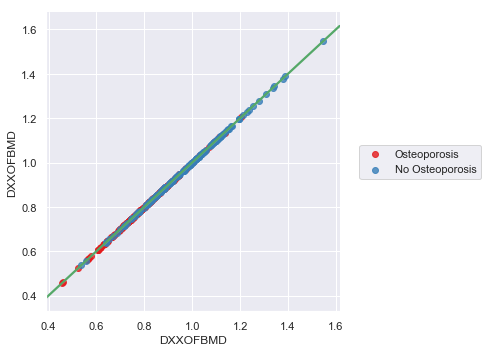

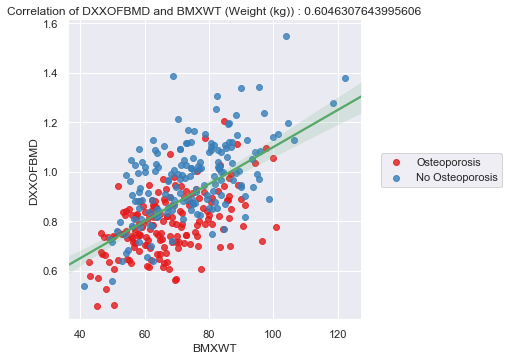

BMXARMC


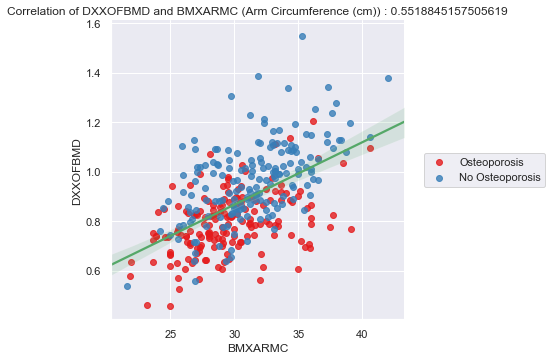

RIDAGEYR


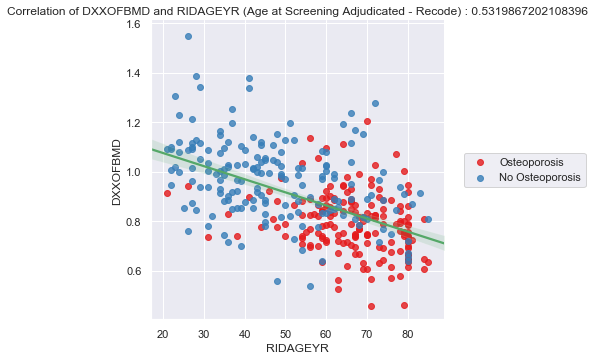

RIAGENDR


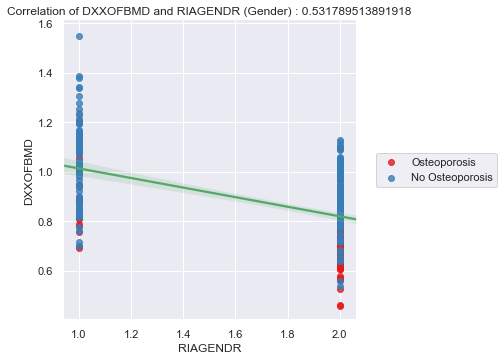

BMXHT


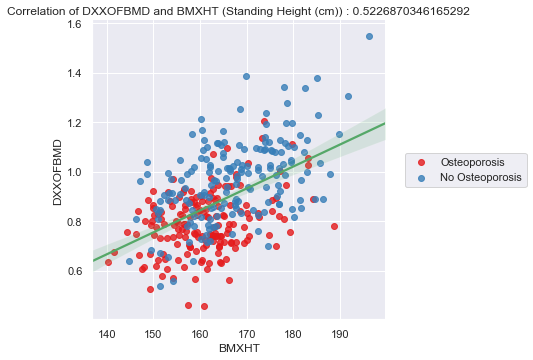

BMXARML


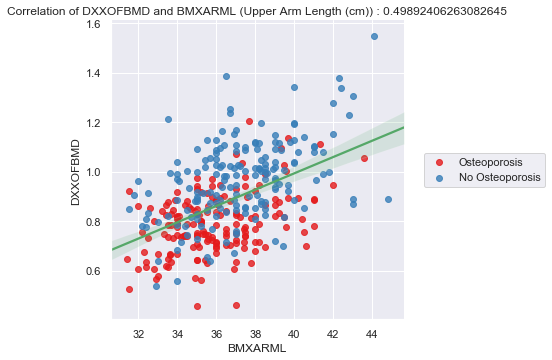

BMXLEG


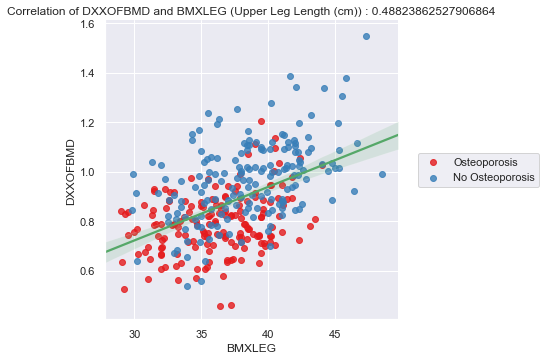

URXUCR


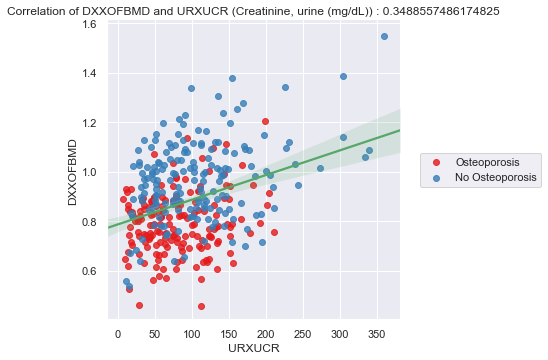

BMXBMI


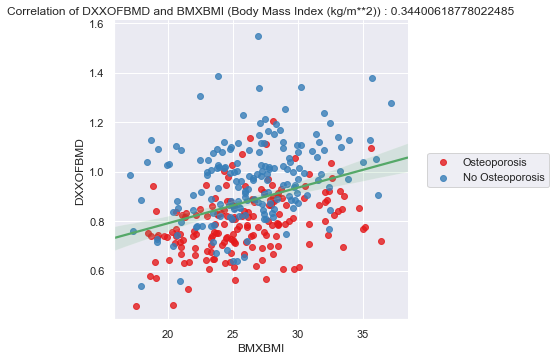

LBXRBCSI


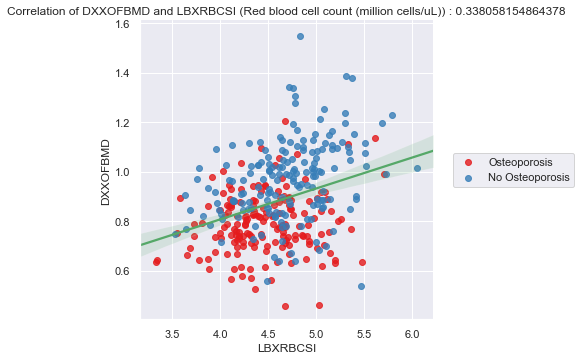

LBXHCT


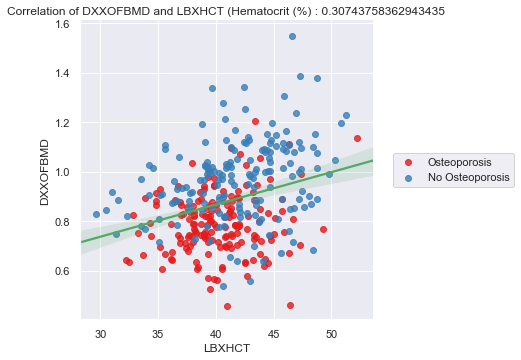

LBXHGB


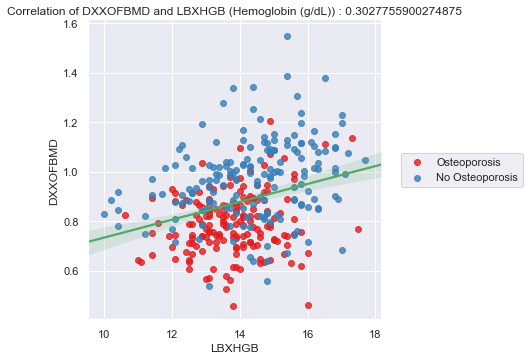

BMXWAIST


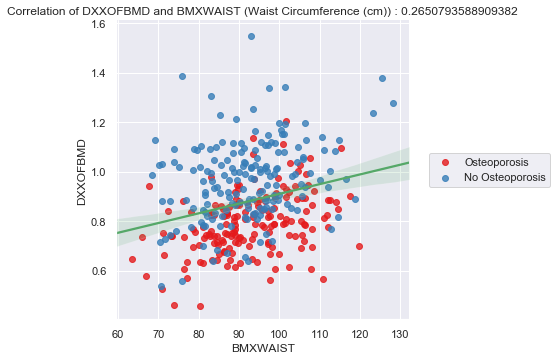

AverageSY
'AverageSY'
BPXML1


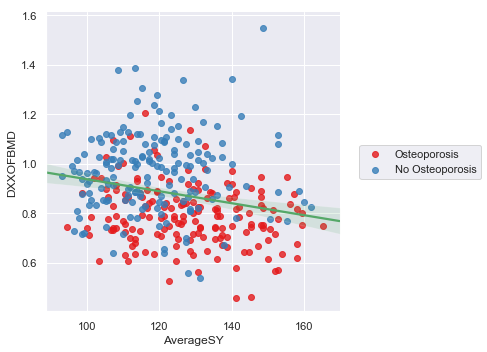

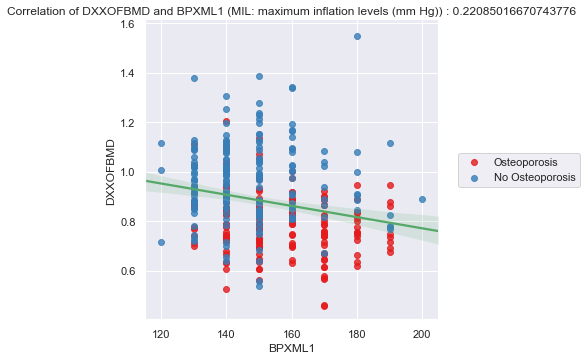

In [21]:
# df_use = df
df_use = df_s
X_test, y_test = create_features_and_columns(df_s, BMD_filter_out, BMD_feature_list)
print_corr_with_label_test(BMD_feature_list[7], df_use, X_test, y_test)

## Show Correlation of Features and having OS

In [22]:
def get_Mean_Tuple(label, feature_amount, X, y, classifier):
#     test = get_correlations_with_label(label, X, y)
#     if feature_amount <= len(test.T.columns):
#         test_df = df[test.T.columns[0:0 + feature_amount+1]]
#     else :
#         test_df = df[test.T.columns]
    test_df = df[corr_df.T.columns[0:0 + feature_amount+1]]
    X_test_features, y_test_target = create_features_and_columns2(test_df, label)
    X_train, X_test, y_train, y_test = train_test_split(X_test_features, y_test_target, test_size=0.2, random_state=0)
    my_model = None
    if classifier == 'LR': my_model = LinearRegression()
    elif classifier == 'RFR': my_model = RandomForestRegressor(random_state=0, n_estimators=50)
    elif classifier == 'ANN': my_model = MLPRegressor(activation='logistic', alpha=1, solver = "lbfgs", hidden_layer_sizes=(10,), random_state=0)
    else: my_model = MLPRegressor(activation='logistic', alpha=10,random_state=0)
    my_model.fit(X_train, y_train)
    y_predict = my_model.predict(X_test)
    mean_value = np.sqrt(mean_squared_error(y_test, y_predict))
    cv_mean_squared_error = cross_val_score(my_model, X_test_features, y_test_target, cv=5,scoring='neg_mean_squared_error')
    cv_mean_squared_error = np.abs(cv_mean_squared_error)
    cv_mean_squared_error = np.sqrt(cv_mean_squared_error)
    cv_mean_squared_error = np.mean(cv_mean_squared_error)
    print(cv_mean_squared_error)
    print("Mean 5-Fold mean_squared_error: ", str(cv_mean_squared_error))
    return (feature_amount,cv_mean_squared_error)

def get_mean_value_with_label_tuple(label, X, y, regr_classifier, number_of_features=[3,4,5,6,7,8,9,10,11,12,13,14,15]):
    mean_values = [get_Mean_Tuple(label, number, X, y, regr_classifier) for number in number_of_features]
    return mean_values

def get_Mape_Tuple(label, feature_amount, X, y, classifier):
#     test = get_correlations_with_label(label, X, y,)
#     if feature_amount <= len(test.T.columns):
#         test_df = df[test.T.columns[0:0 + feature_amount+1]]
#     else :
#         test_df = df[test.T.columns]
    test_df = df[corr_df.T.columns[0:0 + feature_amount+1]]
    X_test_features, y_test_target = create_features_and_columns2(test_df, label)
    X_train, X_test, y_train, y_test = train_test_split(X_test_features, y_test_target, test_size=0.2, random_state=0)
    my_model = None
    y_predict = None
    if classifier == 'LR': 
        my_model = LinearRegression()
        my_model.fit(X_train, y_train)
        y_predict = my_model.predict(X_test)
    elif classifier == 'RFR': 
        my_model = RandomForestRegressor(random_state=0, n_estimators=50)
        my_model.fit(X_train, y_train)
        y_predict = my_model.predict(X_test)
        y_predict = [[val] for val in y_predict]
        y_predict= np.asarray(y_predict)
    elif classifier == 'ANN': 
        my_model = MLPRegressor(activation='logistic', alpha=1,solver = "lbfgs", hidden_layer_sizes=(10,), random_state=0)
        my_model.fit(X_train, y_train.values.ravel())
        y_predict = my_model.predict(X_test)
        y_predict = [[val] for val in y_predict]
        y_predict= np.asarray(y_predict)
    else: 
        my_model = MLPRegressor(activation='logistic', alpha=10,solver = "lbfgs",random_state=0)
        my_model.fit(X_train, y_train.values.ravel())
        y_predict = my_model.predict(X_test)
        y_predict = [[val] for val in y_predict]
        y_predict= np.asarray(y_predict)

    cv_mean_absolute_error = cross_val_score(my_model, X_test_features, y_test_target, cv=5,scoring='neg_mean_absolute_error')
    cv_mean_absolute_error = np.abs(cv_mean_absolute_error)
    cv_mean_absolute_error = np.mean(cv_mean_absolute_error)
    print(cv_mean_absolute_error)
    print("Mean 5-Fold Mean Absolute Error: ", str(cv_mean_absolute_error))
    return (feature_amount,cv_mean_absolute_error)

def get_mape_value_with_label_tuple(label, X, y, regr_classifier, number_of_features=[3,4,5,6,7,8,9,10,11,12,13,14,15]):
    mape_values = [get_Mape_Tuple(label, number, X, y, regr_classifier) for number in number_of_features]
    return mape_values


## Find the best ANN and RFR parameters

In [23]:
# def test_ANN(label, feature_amount, activation_type, solver_type, alpha_value, layer):
#     test_df = df[corr_df.T.columns[0:0 + feature_amount+1]]
#     X_test_features, y_test_target = create_features_and_columns2(test_df, label)
#     X_train, X_test, y_train, y_test = train_test_split(X_test_features, y_test_target, test_size=0.3, random_state=0)
#     my_model = MLPRegressor(activation=activation_type, solver = solver_type, alpha=alpha_value, hidden_layer_sizes = layer, random_state=0)
#     my_model.fit(X_train, y_train)
#     y_predict = my_model.predict(X_test)
#     mean_value = np.sqrt(mean_squared_error(y_test, y_predict))
#     return (feature_amount,mean_value)

# def test_ANN_tuple(label,activation_type, solver_type, alpha_value, layers, number_of_features=[5,10,15,20,25,30,35]):
#     mean_values = [test_ANN(label, number, activation_type,solver_type, alpha_value, layers ) for number in number_of_features]
#     return mean_values

# def print_regression_graph_ANN(label, activation_type, solver, alpha_value, layers, numbers=[5,10,15,20,25,30,35]):
#     ANN_M_V2 = test_ANN_tuple(label, activation_type, solver, alpha_value, layers, numbers)
#     plt.plot(*zip(*ANN_M_V2))
#     plt.title(label + ' ANN ' + activation_type + " - " +  solver + " - " + str(alpha_value) + " - " + str(layers) + ' RSME V.S Features')
#     plt.xlabel('Feature Number')
#     plt.ylabel('RSME')
#     plt.show()


# print_regression_graph_ANN(BMD_feature_list[7], "tanh", "lbfgs", 10, (10, ))
# print_regression_graph_ANN(BMD_feature_list[7], "tanh", "lbfgs", 10, (10, ), [5,10,15,20,25,30,35,40,45,50,55,60,65,70])

# print_regression_graph_ANN(BMD_feature_list[7], "logistic", "lbfgs", 1, (10, ))
# print_regression_graph_ANN(BMD_feature_list[7], "logistic", "lbfgs", 1, (10, ), [5,10,15,20,25,30,35,40,45,50,55,60,65,70])



In [24]:
# def test_RFR(label, feature_amount,n_est, maxFeat ):
#     test_df = df[corr_df.T.columns[0:0 + feature_amount+1]]
#     X_test_features, y_test_target = create_features_and_columns2(test_df, label)
#     X_train, X_test, y_train, y_test = train_test_split(X_test_features, y_test_target, test_size=0.3, random_state=0)
#     my_model = RandomForestRegressor(random_state=0, n_estimators=n_est,max_features= maxFeat)
#     my_model.fit(X_train, y_train)
#     y_predict = my_model.predict(X_test)
#     cv_mean_squared_error = cross_val_score(my_model, X_test_features, y_test_target, cv=5,scoring='neg_mean_squared_error')
#     cv_mean_squared_error = np.abs(cv_mean_squared_error)
#     cv_mean_squared_error = np.sqrt(cv_mean_squared_error)
#     cv_mean_squared_error = np.mean(cv_mean_squared_error)
#     return (feature_amount,cv_mean_squared_error)


# def test_RFR_tuple(label,n_est, maxFeat, number_of_features=[5,10,15,20,25,30,35,40,45,50,55,60,65,70]):
#     mean_values = [test_RFR(label, number,n_est, maxFeat ) for number in number_of_features]
#     return mean_values

# def print_regression_graph_RFR(label,n_est, maxFeat):
#     RFR_M_V2 = test_RFR_tuple(label,n_est, maxFeat )
#     plt.plot(*zip(*RFR_M_V2))
#     plt.title(label + ' RFR ' + str(n_est) + " - " +  str(maxFeat) + ' RSME V.S Features')
#     plt.xlabel('Feature Number')
#     plt.ylabel('RSME')
#     plt.show()
    
# n_estimators_test = [10,20,30,40,50,60,70,80,90,100]
# max_features_test = [None, "sqrt"]

# for f in max_features_test:
#     for n in n_estimators_test:
#         print_regression_graph_RFR(BMD_feature_list[7], n, f)


# Compare LR, RFR, and ANN with RSME and MAPE

('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR'])
0.1291323968579838
('Mean 5-Fold mean_squared_error: ', '0.1291323968579838')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG'])
0.12729500411462272
('Mean 5-Fold mean_squared_error: ', '0.12729500411462272')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI'])
0.1175344552467191
('Mean 5-Fold mean_squared_error: ', '0.1175344552467191')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI'])
0.11647515812875753
('Mean 5-Fold mean_squared_error: ', '0.11647515812875753')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST'

/Users/safamahbub/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/Users/safamahbub/anaconda3/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


0.1460128448215591
('Mean 5-Fold mean_squared_error: ', '0.1460128448215591')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG'])
0.1361420535424706
('Mean 5-Fold mean_squared_error: ', '0.1361420535424706')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI'])
0.1208920194475259
('Mean 5-Fold mean_squared_error: ', '0.1208920194475259')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI'])
0.11945816840057306
('Mean 5-Fold mean_squared_error: ', '0.11945816840057306')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBXTC', 'BMXT

/Users/safamahbub/anaconda3/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.12917589690453007
('Mean 5-Fold mean_squared_error: ', '0.12917589690453007')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG'])
0.1281236801848487
('Mean 5-Fold mean_squared_error: ', '0.1281236801848487')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI'])
0.11997663712577947
('Mean 5-Fold mean_squared_error: ', '0.11997663712577947')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI'])
0.11944322185543536
('Mean 5-Fold mean_squared_error: ', '0.11944322185543536')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBXTC', '

0.09242585601834323
('Mean 5-Fold Mean Absolute Error: ', '0.09242585601834323')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBXTC', 'BMXTRI', 'LBXMCVSI'])
0.09211908865646523
('Mean 5-Fold Mean Absolute Error: ', '0.09211908865646523')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBXTC', 'BMXTRI', 'LBXMCVSI', 'BPXML1', 'LBXBCD', 'LBXRDW', 'AverageSY', 'LBXMCHSI'])
0.09216459559151652
('Mean 5-Fold Mean Absolute Error: ', '0.09216459559151652')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', '

/Users/safamahbub/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.11570378160622767
('Mean 5-Fold Mean Absolute Error: ', '0.11570378160622767')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG'])
0.10861775039141133
('Mean 5-Fold Mean Absolute Error: ', '0.10861775039141133')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI'])
0.09562894601850716
('Mean 5-Fold Mean Absolute Error: ', '0.09562894601850716')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI'])
0.09496247704642183
('Mean 5-Fold Mean Absolute Error: ', '0.09496247704642183')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBX

0.09412694805568925
('Mean 5-Fold Mean Absolute Error: ', '0.09412694805568925')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBXTC', 'BMXTRI', 'LBXMCVSI'])
0.09325979969603616
('Mean 5-Fold Mean Absolute Error: ', '0.09325979969603616')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBXTC', 'BMXTRI', 'LBXMCVSI', 'BPXML1', 'LBXBCD', 'LBXRDW', 'AverageSY', 'LBXMCHSI'])
0.09261725139236683
('Mean 5-Fold Mean Absolute Error: ', '0.09261725139236683')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', '

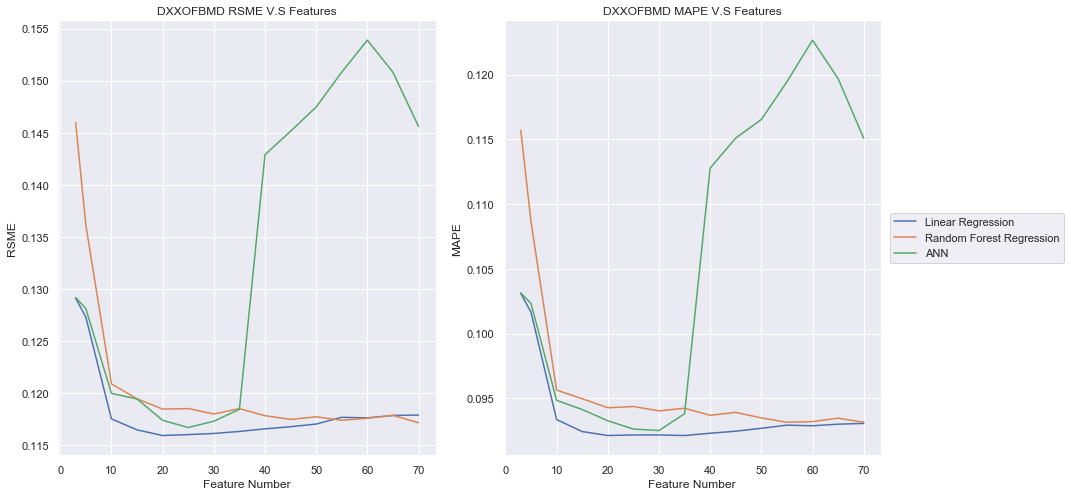

('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR'])
0.1291323968579838
('Mean 5-Fold mean_squared_error: ', '0.1291323968579838')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT'])
0.1287872341574668
('Mean 5-Fold mean_squared_error: ', '0.1287872341574668')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG'])
0.12729500411462272
('Mean 5-Fold mean_squared_error: ', '0.12729500411462272')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML'])
0.126695913933269
('Mean 5-Fold mean_squared_error: ', '0.126695913933269')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR'])
0.11789844361392036
('Mean 5-Fold mean_squared_error: ', '0.11789844361392036')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI'])


0.11901576477314837
('Mean 5-Fold mean_squared_error: ', '0.11901576477314837')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBXTC', 'BMXTRI', 'LBXMCVSI'])
0.11846966322896957
('Mean 5-Fold mean_squared_error: ', '0.11846966322896957')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR'])
0.12917589690453007
('Mean 5-Fold mean_squared_error: ', '0.12917589690453007')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT'])
0.12907849091563645
('Mean 5-Fold mean_squared_error: ', '0.12907849091563645')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG'])
0.1281236801848487
('Mean 5-Fold mean_squared_error: ', '0.1281236801848487')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG

0.09208669263606359
('Mean 5-Fold Mean Absolute Error: ', '0.09208669263606359')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBXTC', 'BMXTRI', 'LBXMCVSI'])
0.09211908865646523
('Mean 5-Fold Mean Absolute Error: ', '0.09211908865646523')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR'])
0.11570378160622767
('Mean 5-Fold Mean Absolute Error: ', '0.11570378160622767')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT'])
0.10975450533545934
('Mean 5-Fold Mean Absolute Error: ', '0.10975450533545934')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG'])
0.10861775039141133
('Mean 5-Fold Mean Absolute Error: ', '0.10861775039141133')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 

0.0949148731813165
('Mean 5-Fold Mean Absolute Error: ', '0.0949148731813165')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBXTC'])
0.09476591726639627
('Mean 5-Fold Mean Absolute Error: ', '0.09476591726639627')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBXTC', 'BMXTRI'])
0.0930081252799248
('Mean 5-Fold Mean Absolute Error: ', '0.0930081252799248')
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIAGENDR', 'BMXHT', 'BMXLEG', 'BMXARML', 'RIDAGEYR', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'BMXWAIST', 'LBXHCT', 'LBXHGB', 'LBXSUA', 'LBXSATSI', 'BMXSUB', 'LBXSAL', 'LBXTC', 'BMXTRI', 'LBXMCVSI'])
0.09325979969603616
('Mean 5-F

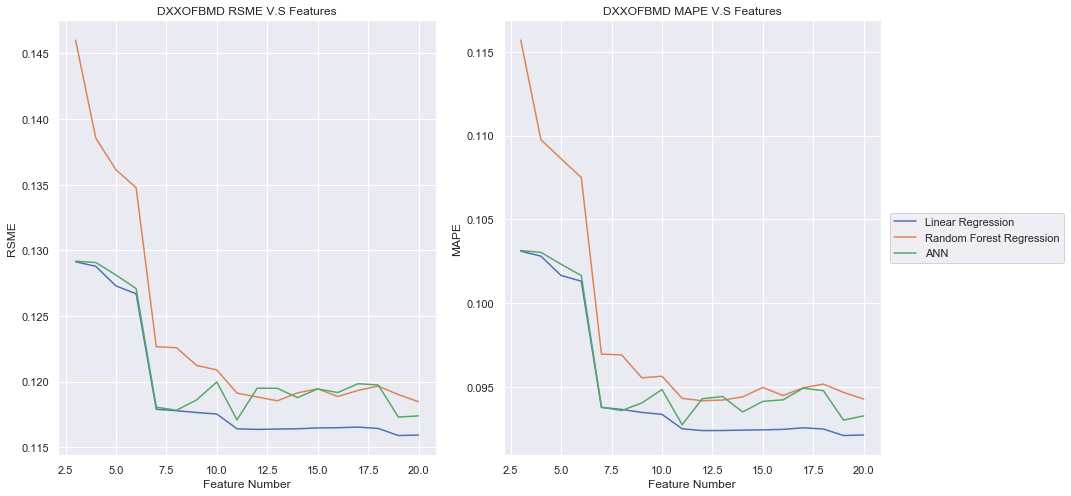

In [25]:
def print_regression_graphs(label, numbers=[3,5,10,15,20,25,30,35,40,45,50,55,60,65,70]):
    LR_RSME = get_mean_value_with_label_tuple(label, X, y, 'LR', numbers)
    RFR_RSME = get_mean_value_with_label_tuple(label, X, y, 'RFR', numbers)
    ANN_RSME = get_mean_value_with_label_tuple(label, X, y, 'ANN', numbers)
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(*zip(*LR_RSME))
    plt.plot(*zip(*RFR_RSME))
    plt.plot(*zip(*ANN_RSME))
    plt.title(label + ' RSME V.S Features')
    plt.xlabel('Feature Number')
    plt.ylabel('RSME')
        
    LR_MAPE = get_mape_value_with_label_tuple(label, X, y, 'LR', numbers)
    RFR_MAPE = get_mape_value_with_label_tuple(label, X, y, 'RFR', numbers)
    ANN_MAPE = get_mape_value_with_label_tuple(label, X, y, 'ANN', numbers)
    plt.subplot(1, 2, 2)
    plt.plot(*zip(*LR_MAPE))
    plt.plot(*zip(*RFR_MAPE))
    plt.plot(*zip(*ANN_MAPE))
    plt.title(label + ' MAPE V.S Features')
    plt.xlabel('Feature Number')
    plt.ylabel('MAPE')
    
    plt.legend(['Linear Regression', 'Random Forest Regression', 'ANN'], loc='center right', bbox_to_anchor=(1.50, 0.5))
    plt.tight_layout()
    plt.show()
    
print_regression_graphs(BMD_feature_list[7])
print_regression_graphs(BMD_feature_list[7], [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])




# Classification Algorithms

In [26]:
def print_all_scores(scores_list, title):
    print(title)
    print("Accuracy: ", str(scores_list[0]))
    print("Confusion Matrix: ",str(scores_list[1]))
    print("Recall Score: ",str(scores_list[2]))
    print("Precision Score: ",str(scores_list[3]))
    print("F1 Score: ",str(scores_list[4]))
    
def print_all_scores2(scores_list, title):
    print(title)
    print("Accuracy: ", str(scores_list[0]))
    print("Confusion Matrix: ",str(scores_list[1]))
    print("Recall Score: ",str(scores_list[2]))

In [27]:
# X_s
# y_s[["OSQ060"]]

## Just Feat

In [28]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s[["OSQ060"]], test_size=0.3, random_state=0)

def do_rf(X_train, X_test, y_train, y_test):
    my_RandomForest = RandomForestClassifier(n_estimators = 60, bootstrap = True, random_state=0)
    my_RandomForest.fit(X_train, y_train)
    y_pred = my_RandomForest.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    rs = recall_score(y_test, y_pred,average=None)
    ps = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return (accuracy,cm,rs,ps,f1)

def do_rf_cv(X, y):
    my_RandomForest = RandomForestClassifier(n_estimators = 60, bootstrap = True, random_state=0)
    accuracy = np.mean(cross_val_score(my_RandomForest, X, y, cv=4,scoring='accuracy'))
    rs = np.mean(cross_val_score(my_RandomForest, X, y, cv=4,scoring='recall'))
    ps = np.mean(cross_val_score(my_RandomForest, X, y, cv=4,scoring='precision'))
    f1 = np.mean(cross_val_score(my_RandomForest, X, y, cv=4,scoring='f1'))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    my_RandomForest.fit(X_train, y_train)
    y_pred = my_RandomForest.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return (accuracy,cm,rs,ps,f1)

def do_lr(X_train, X_test, y_train, y_test):
    my_logreg = LogisticRegression()
    my_logreg.fit(X_train, y_train)
    y_pred = my_logreg.predict(X_test)    
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    rs = recall_score(y_test, y_pred,average=None)
    ps = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return (accuracy,cm,rs,ps,f1)

def do_lr_cv(X,y):
    my_logreg = LogisticRegression()
    accuracy = np.mean(cross_val_score(my_logreg, X, y, cv=4,scoring='accuracy'))
    rs = np.mean(cross_val_score(my_logreg, X, y, cv=4,scoring='recall'))
    ps = np.mean(cross_val_score(my_logreg, X, y, cv=4,scoring='precision'))
    f1 = np.mean(cross_val_score(my_logreg, X, y, cv=4,scoring='f1'))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    my_logreg.fit(X_train, y_train)
    y_pred = my_logreg.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    return (accuracy,cm,rs,ps,f1)

def do_knn(X_train, X_test, y_train, y_test,k=5):
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    rs = recall_score(y_test, y_pred,average=None)
    ps = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return (accuracy,cm,rs,ps,f1)

def do_knn_cv(X,y,k=5):
    my_knn = KNeighborsClassifier(n_neighbors=k) 
    accuracy = np.mean(cross_val_score(my_knn, X, y, cv=4,scoring='accuracy'))
    rs = np.mean(cross_val_score(my_knn, X, y, cv=4,scoring='recall'))
    ps = np.mean(cross_val_score(my_knn, X, y, cv=4,scoring='precision'))
    f1 = np.mean(cross_val_score(my_knn, X, y, cv=4,scoring='f1'))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    my_knn.fit(X_train,y_train)
    y_pred = my_knn.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return (accuracy,cm,rs,ps,f1)

def do_svm(X_train, X_test, y_train, y_test):
    my_svm = svm.SVC(C=1, kernel='rbf', gamma=0.0005, random_state=1)
    my_svm.fit(X_train, y_train)
    y_pred = my_svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    rs = recall_score(y_test, y_pred,average=None)
    return (accuracy,cm,rs)

def do_svm_cv(X,y):
    my_svm = svm.SVC(C=1, kernel='rbf', gamma=0.0005, random_state=1)
    accuracy = np.mean(cross_val_score(my_svm, X, y, cv=4,scoring='accuracy'))
    rs = np.mean(cross_val_score(my_svm, X, y, cv=4,scoring='recall'))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    my_svm.fit(X_train,y_train)
    y_pred = my_svm.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return (accuracy,cm,rs)

def do_ann(X_train, X_test, y_train, y_test, alphaV=10, layers=(10,)):
    my_ann = MLPClassifier(hidden_layer_sizes=layers, activation= 'logistic', 
                       solver='lbfgs', alpha=alphaV, random_state=0)
    my_ann.fit(X_train, y_train)
    y_pred = my_ann.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    rs = recall_score(y_test, y_pred,average=None)
    return (accuracy,cm,rs)

# def do_ann_cv(X,y, alphaV=10, layers=(10,)):
#     my_ann = MLPClassifier(hidden_layer_sizes=layers, activation= 'logistic', 
#                        solver='lbfgs', alpha=alphaV, random_state=0)
#     accuracy = np.mean(cross_val_score(my_ann, X, y, cv=4,scoring='accuracy'))
#     rs = np.mean(cross_val_score(my_ann, X, y, cv=4,scoring='recall'))
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
#     my_ann.fit(X_train,y_train)
#     y_pred = my_ann.predict(X_test)
#     cm = confusion_matrix(y_test, y_pred)
#     return (accuracy,cm,rs)

k_val = 2
scores_knn = do_knn(X_train_s, X_test_s, y_train_s, y_test_s, k_val)
print_all_scores(scores_knn, "KNN with K:" + str(k_val))

scores_knn_cv = do_knn_cv(X_s, y_s[["OSQ060"]], k_val)
print_all_scores(scores_knn_cv, "KNN CV with K:" + str(k_val))

scores_rf = do_rf(X_train_s, X_test_s, y_train_s, y_test_s)
print_all_scores(scores_rf, "Random Forest")

scores_rf_cv = do_rf_cv(X_s, y_s[["OSQ060"]])
print_all_scores(scores_rf_cv, "Random Forest CV")

scores_lr = do_lr(X_train_s, X_test_s, y_train_s, y_test_s)
print_all_scores(scores_lr, "Logistic Regression")

scores_lr_cv = do_lr_cv(X_s, y_s[["OSQ060"]])
print_all_scores(scores_lr_cv, "Logistic Regression CV")

scores_svm = do_svm(X_train_s, X_test_s, y_train_s, y_test_s)
print_all_scores2(scores_svm, "SVM")

scores_svm_cv = do_svm_cv(X_s, y_s[["OSQ060"]])
print_all_scores2(scores_svm_cv, "SVM CV")

scores_ann = do_ann(X_train_s, X_test_s, y_train_s, y_test_s, 10, (10,))
print_all_scores2(scores_ann, "ANN")


/Users/safamahbub/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/safamahbub/anaconda3/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KNN with K:2
('Accuracy: ', '0.6153846153846154')
('Confusion Matrix: ', '[[43 15]\n [25 21]]')
('Recall Score: ', '[0.74137931 0.45652174]')
('Precision Score: ', '0.6323529411764706')
('F1 Score: ', '0.6825396825396826')


/Users/safamahbub/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:71: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/safamahbub/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


KNN CV with K:2
('Accuracy: ', '0.5693710359408035')
('Confusion Matrix: ', '[[61 15]\n [40 23]]')
('Recall Score: ', '0.7345401691331924')
('Precision Score: ', '0.5537087912087912')
('F1 Score: ', '0.6305720607601676')
Random Forest
('Accuracy: ', '0.7596153846153846')
('Confusion Matrix: ', '[[44 14]\n [11 35]]')
('Recall Score: ', '[0.75862069 0.76086957]')
('Precision Score: ', '0.8')
('F1 Score: ', '0.7787610619469026')


/Users/safamahbub/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest CV
('Accuracy: ', '0.7317653276955602')
('Confusion Matrix: ', '[[57 19]\n [16 47]]')
('Recall Score: ', '0.7238372093023256')
('Precision Score: ', '0.7328693977591036')
('F1 Score: ', '0.7231245995293161')
Logistic Regression
('Accuracy: ', '0.7596153846153846')
('Confusion Matrix: ', '[[45 13]\n [12 34]]')
('Recall Score: ', '[0.77586207 0.73913043]')
('Precision Score: ', '0.7894736842105263')
('F1 Score: ', '0.7826086956521741')


/Users/safamahbub/anaconda3/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/safamahbub/anaconda3/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression CV
('Accuracy: ', '0.7113504228329809')
('Confusion Matrix: ', '[[60 16]\n [21 42]]')
('Recall Score: ', '0.7057346723044398')
('Precision Score: ', '0.7082168737060042')
('F1 Score: ', '0.6995676861530521')
SVM
('Accuracy: ', '0.4423076923076923')
('Confusion Matrix: ', '[[ 0 58]\n [ 0 46]]')
('Recall Score: ', '[0. 1.]')
SVM CV
('Accuracy: ', '0.5058139534883721')
('Confusion Matrix: ', '[[ 0 76]\n [ 0 63]]')
('Recall Score: ', '0.2616279069767442')
ANN
('Accuracy: ', '0.5576923076923077')
('Confusion Matrix: ', '[[17 41]\n [ 5 41]]')
('Recall Score: ', '[0.29310345 0.89130435]')


/Users/safamahbub/anaconda3/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
# n_estimators, max_depth, min_samples_leaf, max_features, bootstrap=False

def do_rf_cv_param(X, y, ne,md,msl,mf,b):
    my_RandomForest = RandomForestClassifier(n_estimators = ne, max_depth =  md, min_samples_leaf = msl, max_features=mf, bootstrap = b, random_state=0)
    accuracy = np.mean(cross_val_score(my_RandomForest, X, y, cv=4,scoring='accuracy'))
    return accuracy
#     rs = np.mean(cross_val_score(my_RandomForest, X, y, cv=4,scoring='recall'))
#     ps = np.mean(cross_val_score(my_RandomForest, X, y, cv=4,scoring='precision'))
#     f1 = np.mean(cross_val_score(my_RandomForest, X, y, cv=4,scoring='f1'))
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
#     my_RandomForest.fit(X_train, y_train)
#     y_pred = my_RandomForest.predict(X_test)
#     cm = confusion_matrix(y_test, y_pred)
#     return (accuracy,cm,rs,ps,f1)


max = 0
for boot in [True, False]:
    for feat in ["auto","sqrt","log2",None]:
        for md in range(10,101,10):
            for est in range(10,101, 10):
                scores_rf_cv_param = do_rf_cv_param(X_s, y_s[["OSQ060"]], est,md,1,feat,boot)
                if scores_rf_cv_param > max: 
                    max = scores_rf_cv_param
                    print("N_estimators: " + str(est) + ", Boostrap: " + str(boot) + ", Max_features: " + str(feat) + "-- Accuracy: " + str(scores_rf_cv_param))
        
        
        

N_estimators: 10, Boostrap: True, Max_features: auto-- Accuracy: 0.7171643763213531
N_estimators: 20, Boostrap: True, Max_features: auto-- Accuracy: 0.7282637420718816
N_estimators: 30, Boostrap: True, Max_features: auto-- Accuracy: 0.7399577167019028
N_estimators: 40, Boostrap: True, Max_features: auto-- Accuracy: 0.7459698731501058
N_estimators: 60, Boostrap: True, Max_features: auto-- Accuracy: 0.7517838266384779
N_estimators: 80, Boostrap: True, Max_features: auto-- Accuracy: 0.757531712473573
N_estimators: 90, Boostrap: True, Max_features: auto-- Accuracy: 0.7632135306553911
N_estimators: 20, Boostrap: True, Max_features: log2-- Accuracy: 0.7661205073995772


KeyboardInterrupt: 

In [51]:
def do_lr_cv_param(X,y, solver_option, class_weight_option, fit_intercept_option, C_option, max_iter_option):
    my_logreg = LogisticRegression(solver = solver_option, class_weight = class_weight_option,fit_intercept=fit_intercept_option,C=C_option,max_iter=max_iter_option,random_state = 0)
    accuracy = np.mean(cross_val_score(my_logreg, X, y, cv=4,scoring='accuracy'))
    return accuracy
#     rs = np.mean(cross_val_score(my_logreg, X, y, cv=4,scoring='recall'))
#     ps = np.mean(cross_val_score(my_logreg, X, y, cv=4,scoring='precision'))
#     f1 = np.mean(cross_val_score(my_logreg, X, y, cv=4,scoring='f1'))
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
#     my_logreg.fit(X_train, y_train)
#     y_pred = my_logreg.predict(X_test)
#     cm = confusion_matrix(y_test, y_pred)

#     return (accuracy,cm,rs,ps,f1)

solver_options = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
class_weight_options = ["balanced", None]
fit_intercept_options = [True, False]
C_options = [0.001, 0.01, 0.1, 1, 10, 100]
max_iter_options = [10, 50, 100, 150]

max_lr = 0
for fio in fit_intercept_options:
    for cwo in class_weight_options:
        for mio in max_iter_options:
            for co in C_options:
                for so in solver_options:
                    scores_lr_cv_param = do_lr_cv_param(X_s, y_s[["OSQ060"]], so,cwo,fio,co,mio)
                    if scores_lr_cv_param > max: 
                        max_lr = scores_lr_cv_param
                        print("Solver: " + str(so) + ", C: " + str(co) + ", max Iter: " + str(mio) + ", Class Weight: " + str(cwo) + ", Fit Intercept: " + str(fio) + "-- Accuracy: " + str(scores_lr_cv_param))
        
        


/Users/safamahbub/anaconda3/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/safamahbub/anaconda3/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/safamahbub/anaconda3/lib/python2.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/safamahbub/anaconda3/lib/python2.7/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/safamahbub/anaconda3/lib/python2.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line s

Solver: lbfgs, C: 0.01, max Iter: 150, Class Weight: balanced, Fit Intercept: True-- Accuracy: 0.74848044397463
Solver: lbfgs, C: 0.1, max Iter: 150, Class Weight: balanced, Fit Intercept: True-- Accuracy: 0.7484804439746301
Solver: lbfgs, C: 0.01, max Iter: 150, Class Weight: None, Fit Intercept: True-- Accuracy: 0.74848044397463
Solver: lbfgs, C: 0.1, max Iter: 150, Class Weight: None, Fit Intercept: True-- Accuracy: 0.7484804439746301


In [ ]:
# kernel_options = ["linear", "poly", "rbf", "sigmoid", "precomputed"]
C_options = [0.001, 0.01, 0.1, 1, 10, 100]
gamma_options =[0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, "auto"]

def do_svm_cv_param(X,y, kernal_val,c_val, gamma_val):
    my_svm = svm.SVC(C=c_val, kernel=kernal_val, gamma=gamma_val, random_state=0)
    accuracy = np.mean(cross_val_score(my_svm, X, y, cv=4,scoring='accuracy'))
    return accuracy
#     rs = np.mean(cross_val_score(my_svm, X, y, cv=4,scoring='recall'))
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
#     my_svm.fit(X_train,y_train)
#     y_pred = my_svm.predict(X_test)
#     cm = confusion_matrix(y_test, y_pred)
#     return (accuracy,cm,rs)

max_svc = 0
for k in kernel_options:
#     for c in C_options:
    for g in gamma_options:
        score_svm_cv_param = do_svm_cv_param(X_s, y_s[["OSQ060"]], k, 1, g)
        print("kernel: " + str(k) + ", C: " + str(1) + ", Gamma: " + str(g) + "-- Accuracy: " + str(score_svm_cv_param))
        if score_svm_cv_param > max_svc:
            max_svc = score_svm_cv_param

print("BEST ACCURACY")
print("kernel: " + str(k) + ", C: " + str(c) + ", Gamma: " + str(g) + "-- Accuracy: " + str(max_svc))
                
                

In [62]:
python -m xport /Users/safamahbub/Downloads/DXXFEM_F.xpt > example.csv

SyntaxError: invalid syntax (<ipython-input-62-2027b5002d36>, line 1)

In [ ]:
# X_s
# N_estimators: 20, Boostrap: True, Max_features: log2-- Accuracy: 0.7661205073995772

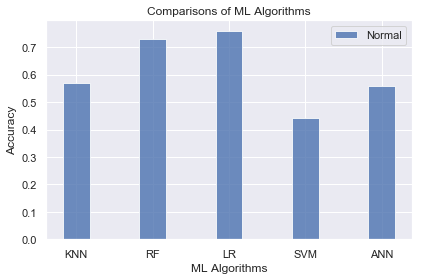

In [38]:
# import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()

classifiers = ['KNN', 'RF', 'LR', 'SVM', 'ANN']
accuracies = [scores_knn_cv[0], scores_rf_cv[0], scores_lr[0], scores_svm[0], scores_ann[0]]
 
# Create the plot
index = np.arange(len(classifiers))
bar_width = 0.35
opacity = 0.8
 
normal = plt.bar(index, accuracies, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Normal')
 
plt.xlabel('ML Algorithms')
plt.ylabel('Accuracy')
plt.title('Comparisons of ML Algorithms')
plt.xticks(index, classifiers)
plt.legend()
 
plt.tight_layout()
plt.show()

## Just BMD

In [30]:
# # corr_df = get_correlations_with_label_test(BMD_feature_list[7], X, y, 0)

# def get_predict_label(label, feature_amount, X, y):
#     corr_df = get_correlations_with_label_test(label, X, y, 0)
#     test_df = df[corr_df.T.columns[0:0 + feature_amount+1]]
#     X_test_features, y_test_target = create_features_and_columns2(test_df, label)
#     X_train, X_test, y_train, y_test = train_test_split(X_test_features, y_test_target, test_size=0.2, random_state=0)
#     my_model = LinearRegression()
#     my_model.fit(X_train, y_train)
#     y_predict = my_model.predict(X_train)
#     check = pd.DataFrame(y_predict, columns = [label]) 
#     return check

# y_reg = y[['DXXOFBMD', 'DXXNKBMD', 'DXXTRBMD', 'DXXINBMD', 'DXXWDBMD', 'DXAFMRK', 'DXAFMRD0']]
# y_class = y[['OSQ060']]
# X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(y_reg, y_class, test_size=0.2, random_state=0)

# my_RandomForest = RandomForestClassifier(n_estimators = 19, bootstrap = True, random_state=2)
# my_RandomForest.fit(X_train_check, y_train_check)
# print(X_train_check.columns)
# print(X_train_check.shape)
# y_pred_check = my_RandomForest.predict(X_test_check)
# accuracy_check = accuracy_score(y_test_check, y_pred_check)
# print(accuracy_check)



# testingagain_0 = get_predict_label(BMD_feature_list[0], 11, X, y)
# testingagain_1 = get_predict_label(BMD_feature_list[1], 11, X, y)
# testingagain_2 = get_predict_label(BMD_feature_list[2], 11, X, y)
# testingagain_3 = get_predict_label(BMD_feature_list[3], 11, X, y)
# testingagain_4 = get_predict_label(BMD_feature_list[4], 11, X, y)
# # testingagain_5 = get_predict_label(BMD_feature_list[5], 11)
# testingagain_6 = get_predict_label(BMD_feature_list[6], 11, X, y)
# testingagain_7 = get_predict_label(BMD_feature_list[7], 11, X, y)
# testingagain = pd.concat([testingagain_0, testingagain_1, testingagain_2, testingagain_3, testingagain_4, testingagain_6, testingagain_7], axis=1)
# testingagain
# # X_train_check

# my_RandomForest.fit(testingagain, y_train_check)
# print(testingagain.columns)
# print(testingagain.shape)
# y_pred_check = my_RandomForest.predict(X_test_check)
# accuracy_check = accuracy_score(y_test_check, y_pred_check)
# print(accuracy_check)

In [31]:
# # corr_df = get_correlations_with_label_test(BMD_feature_list[7], X, y, 0)

# def get_predict_label(label, feature_amount, X, y):
#     corr_df = get_correlations_with_label_test(label, X, y, 0)
#     transpose = corr_df.T.columns[0:0 + feature_amount+1]
#     transpose = np.append(transpose,['SEQN'])
# #     return transpose
#     test_df = df_s2[transpose]
# #     test_df = df_s2.loc[df_s2[corr_df.T.columns[0:0 + feature_amount+1]]]
#     X_test_features, y_test_target = create_features_and_columns2(test_df, label)
#     X_train, X_test, y_train, y_test = train_test_split(X_test_features, y_test_target, test_size=0.2, random_state=0)
#     my_model = LinearRegression()
#     my_model.fit(X_train, y_train)
#     y_predict = my_model.predict(X_train)
#     check = pd.DataFrame(y_predict, columns = [label]) 
    
#     return check

# def create_features_and_columns3(df, filter_out_for_features, keep_for_labels):
#     column_names = df.columns
#     features = [f for f in df if f not in filter_out_for_features]
#     target = [f for f in df if f in keep_for_labels ]
#     target.append("SEQN")
#     print("target: ",target)
#     print("features: ",features)
#     X = df[features]
#     y = df[target]
#     return (X,y)

# # df_s2 = merge_df(df_test_transformed_list)
# # df_s2 = split_df(df_s2)
# # df_s2 = df_s2.loc[df["OSQ060"] != 9]
# # # df_s = df_s.drop(['SEQN'], axis=1)
# X_s2,y_s2 = create_features_and_columns2(df_s, BMD_filter_out)

# # # pd.concat([df1, s1], axis=1)
# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s2, y_s2[["OSQ060"]], test_size=0.2, random_state=0)
# my_RandomForest = RandomForestClassifier(n_estimators = 60, bootstrap = True, random_state=0)
# my_RandomForest.fit(X_train_s, y_train_s)
# y_pred_check = my_RandomForest.predict(X_test_s)
# accuracy_check = accuracy_score(y_test_s, y_pred_check)
# print("Just Features: " + str(accuracy_check))


# y_reg = y_s[['DXXOFBMD', 'DXXNKBMD', 'DXXTRBMD', 'DXXINBMD', 'DXXWDBMD', 'DXAFMRK', 'DXAFMRD0']]
# y_class = y_s[['OSQ060']]
# X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(y_reg, y_class, test_size=0.2, random_state=0)
# my_RandomForest.fit(X_train_check, y_train_check)
# y_pred_check = my_RandomForest.predict(X_test_check)
# accuracy_check = accuracy_score(y_test_check, y_pred_check)
# print("Just BMD: " + str(accuracy_check))

# testingagain_0 = get_predict_label(BMD_feature_list[0], 11, X_s2, y_s2)
# # testingagain_0
# testingagain_1 = get_predict_label(BMD_feature_list[1], 11, X_s2, y_s2)
# testingagain_2 = get_predict_label(BMD_feature_list[2], 11, X_s2, y_s2)
# testingagain_3 = get_predict_label(BMD_feature_list[3], 11, X_s2, y_s2)
# testingagain_4 = get_predict_label(BMD_feature_list[4], 11, X_s2, y_s2)
# # testingagain_5 = get_predict_label(BMD_feature_list[5], 11)
# testingagain_6 = get_predict_label(BMD_feature_list[6], 11, X_s2, y_s2)
# testingagain_7 = get_predict_label(BMD_feature_list[7], 11, X_s2, y_s2)
# testingagain = pd.concat([testingagain_0, testingagain_1, testingagain_2, testingagain_3, testingagain_4, testingagain_6, testingagain_7], axis=1)
# my_RandomForest.fit(testingagain, y_train_check)
# y_pred_check = my_RandomForest.predict(X_test_check)
# accuracy_check = accuracy_score(y_test_check, y_pred_check)
# print("Just Prediction of BMD: " + str(accuracy_check))


# # feat_and_rediction_BMD = merge_df([X_train_s, testingagain], merging_value='SEQN')
# # my_RandomForest.fit(feat_and_rediction_BMD, y_train_check)
# # y_pred_check = my_RandomForest.predict(X_test_s)
# # accuracy_check = accuracy_score(y_test_s, y_pred_check)
# # print("Feat and Prediction of BMD: " + str(accuracy_check))
# # feat_and_rediction_BMD
# # # y_s2


In [32]:
# df_s2[["SEQN"]]

In [33]:
# X_s
# y_s
# #X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(X_s, y_class, test_size=0.3, random_state=0)
# #X_train_bmd, X_test_bmd, y_train_bmd, y_test_bmd = train_test_split(X_bmd, y_class, test_size=0.3, random_state=0)
# #X_train_feat_and_bmd, X_test_feat_and_bmd, y_train_feat_and_bmd, y_test_feat_and_bmd = train_test_split(X_feat_and_bmd, y_class, test_size=0.3, random_state=0)

def get_predict_label2(label, feature_amount, X, y):
    corr_df = get_correlations_with_label_test(label, X, y, 0)
    transpose = corr_df.T.columns[0:0 + feature_amount+1]
    test_df = df_s[transpose]
    X_test_features, y_test_target = create_features_and_columns2(test_df, label)
    X_train, X_test, y_train, y_test = train_test_split(X_test_features, y_test_target, test_size=0.3, random_state=0)
    my_model = RandomForestRegressor(random_state=0, n_estimators=50)
#     LinearRegression()
    my_model.fit(X_train, y_train)
    y_predict_train = pd.DataFrame(my_model.predict(X_train))
    y_predict_test = pd.DataFrame(my_model.predict(X_test))
    y_predict_all = y_predict_train.append(y_predict_test, ignore_index=True, sort=False)
    return y_predict_all

X_feat = X_s
X_bmd = y_s[['DXXOFBMD', 'DXXNKBMD', 'DXXTRBMD', 'DXXINBMD', 'DXXWDBMD', 'DXAFMRK', 'DXAFMRD0']]
y_bmd = y_s[['DXXOFBMD', 'DXXNKBMD', 'DXXTRBMD', 'DXXINBMD', 'DXXWDBMD', 'DXAFMRK', 'DXAFMRD0']]
X_feat_and_bmd = pd.concat([X_feat, X_bmd], axis=1)
y_class = y_s[['OSQ060']]

testingagain_0 = get_predict_label2(BMD_feature_list[0], 11, X_feat, y_bmd)
testingagain_1 = get_predict_label2(BMD_feature_list[1], 11, X_feat, y_bmd)
testingagain_2 = get_predict_label2(BMD_feature_list[2], 11, X_feat, y_bmd)
testingagain_3 = get_predict_label2(BMD_feature_list[3], 11, X_feat, y_bmd)
testingagain_4 = get_predict_label2(BMD_feature_list[4], 11, X_feat, y_bmd)
testingagain_6 = get_predict_label2(BMD_feature_list[6], 11, X_feat, y_bmd)
testingagain_7 = get_predict_label2(BMD_feature_list[7], 11, X_feat, y_bmd)
X_pred_bmd = pd.concat([testingagain_0, testingagain_1, testingagain_2, testingagain_3, testingagain_4, testingagain_6, testingagain_7], axis=1)

X_feat_and_pred_bmd = pd.concat([X_feat, X_pred_bmd], axis=1)


scores_rf_cv1 = do_rf_cv(X_feat, y_class)
print_all_scores(scores_rf_cv1, "Just Feat Random Forest CV")

scores_rf_cv2 = do_rf_cv(X_bmd, y_class)
print_all_scores(scores_rf_cv2, "Just BMD Random Forest CV")

scores_rf_cv3 = do_rf_cv(X_feat_and_bmd, y_class)
print_all_scores(scores_rf_cv3, "Both Random Forest CV")

scores_rf_cv4 = do_rf_cv(X_pred_bmd, y_class)
print_all_scores(scores_rf_cv4, "Pred BMD Random Forest CV")

scores_rf_cv5 = do_rf_cv(X_feat_and_pred_bmd, y_class)
print_all_scores(scores_rf_cv5, "Feat and Pred BMD Random Forest CV")



('target: ', ['DXXWDBMD'])
('features: ', ['RIDAGEYR', 'BMXLEG', 'BMXWT', 'BMXARMC', 'BMXHT', 'URXUCR', 'BMXARML', 'RIAGENDR', 'BPXML1', 'AverageSY', 'LBXRBCSI'])


/Users/safamahbub/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


('target: ', ['DXAFMRK'])
('features: ', ['BMXWT', 'BMXARMC', 'BMXBMI', 'BMXWAIST', 'BMXHT', 'RIAGENDR', 'BMXARML', 'LBXSATSI', 'LBXRBCSI', 'RIDAGEYR', 'LBXHGB'])
('target: ', ['DXAFMRD0'])
('features: ', ['BMXWT', 'BMXARMC', 'BMXBMI', 'BMXWAIST', 'BMXARML', 'BMXHT', 'BMXLEG', 'BMXSUB', 'RIAGENDR', 'RIDAGEYR', 'LBXRBCSI'])
('target: ', ['DXXINBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIDAGEYR', 'RIAGENDR', 'BMXHT', 'BMXARML', 'BMXLEG', 'BMXBMI', 'URXUCR', 'LBXRBCSI', 'LBXHCT'])
('target: ', ['DXXTRBMD'])
('features: ', ['BMXWT', 'BMXHT', 'RIAGENDR', 'BMXARML', 'BMXLEG', 'BMXARMC', 'RIDAGEYR', 'URXUCR', 'LBXRBCSI', 'LBXHCT', 'LBXHGB'])
('target: ', ['DXXNKBMD'])
('features: ', ['RIDAGEYR', 'BMXWT', 'BMXARMC', 'BMXLEG', 'BMXHT', 'BMXARML', 'RIAGENDR', 'URXUCR', 'BMXBMI', 'LBXRBCSI', 'BPXML1'])
('target: ', ['DXXOFBMD'])
('features: ', ['BMXWT', 'BMXARMC', 'RIDAGEYR', 'RIAGENDR', 'BMXHT', 'BMXARML', 'BMXLEG', 'URXUCR', 'BMXBMI', 'LBXRBCSI', 'LBXHCT'])


/Users/safamahbub/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Just Feat Random Forest CV
('Accuracy: ', '0.7317653276955602')
('Confusion Matrix: ', '[[57 19]\n [16 47]]')
('Recall Score: ', '0.7238372093023256')
('Precision Score: ', '0.7328693977591036')
('F1 Score: ', '0.7231245995293161')
Just BMD Random Forest CV
('Accuracy: ', '0.74240221987315')
('Confusion Matrix: ', '[[59 17]\n [21 42]]')
('Recall Score: ', '0.7624207188160677')
('Precision Score: ', '0.7323788430100722')
('F1 Score: ', '0.7467165086726226')
Both Random Forest CV
('Accuracy: ', '0.7945956659619451')
('Confusion Matrix: ', '[[65 11]\n [18 45]]')
('Recall Score: ', '0.8091966173361522')
('Precision Score: ', '0.7893928233189519')
('F1 Score: ', '0.7972749071517928')
Pred BMD Random Forest CV
('Accuracy: ', '0.5987711416490487')
('Confusion Matrix: ', '[[42 34]\n [27 36]]')
('Recall Score: ', '0.6009513742071882')
('Precision Score: ', '0.6066854358734975')
('F1 Score: ', '0.6011711589020826')
Feat and Pred BMD Random Forest CV
('Accuracy: ', '0.7691596194503172')
('Confusi

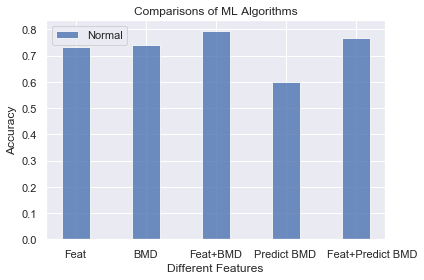

In [34]:
# import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()

classifiers = ['Feat', 'BMD', 'Feat+BMD', 'Predict BMD', '           Feat+Predict BMD']
accuracies = [scores_rf_cv1[0], scores_rf_cv2[0], scores_rf_cv3[0], scores_rf_cv4[0], scores_rf_cv5[0]]

# classifiers = ['Feat', 'Predict BMD', 'Feat+Predict BMD']
# accuracies = [scores_rf_cv1[0], scores_rf_cv4[0], scores_rf_cv5[0]]
 
# Create the plot
index = np.arange(len(classifiers))
bar_width = 0.40
opacity = 0.8
 
normal = plt.bar(index, accuracies, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Normal')
 
plt.xlabel('Different Features')
plt.ylabel('Accuracy')
plt.title('Comparisons of ML Algorithms')
plt.xticks(index, classifiers)
plt.legend()
 
plt.tight_layout()
plt.show()

In [35]:
# def get_predict_label3(label, feature_amount, X, y):
#     corr_df = get_correlations_with_label_test(label, X, y, 0)
#     transpose = corr_df.T.columns[0:0 + feature_amount+1]
#     test_df = df_s[transpose]
#     X_test_features, y_test_target = create_features_and_columns2(test_df, label)
#     X_train, X_test, y_train, y_test = train_test_split(X_test_features, y_test_target, test_size=0.3, random_state=0)
#     my_model = RandomForestRegressor(random_state=0, n_estimators=50)
# #     LinearRegression()
#     my_model.fit(X_train, y_train)
#     y_predict_train = pd.DataFrame(my_model.predict(X_train), columns = [label])
#     return y_predict_train

# def get_predict_label4(label, feature_amount, X, y, dataframe=df_s):
#     corr_df = get_correlations_with_label_test(label, X, y, 0)
#     transpose = corr_df.T.columns[0:0 + feature_amount+1]
#     test_df = df_s[transpose]
#     X_test_features, y_test_target = create_features_and_columns2(test_df, label)
#     X_train, X_test, y_train, y_test = train_test_split(X_test_features, y_test_target, test_size=0.3, random_state=0)
#     my_model = RandomForestRegressor(random_state=0, n_estimators=50)
# #     LinearRegression()
#     my_model.fit(X_train, y_train)
#     y_predict_train = pd.DataFrame(my_model.predict(predict_these), columns = [label])
#     return y_predict_train

X_feat = X_s
X_bmd = y_s[['DXXOFBMD', 'DXXNKBMD', 'DXXTRBMD', 'DXXINBMD', 'DXXWDBMD', 'DXAFMRK', 'DXAFMRD0']]
X_feat_and_bmd = pd.concat([X_feat, X_bmd], axis=1)
y_class = y_s[['OSQ060']]
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(X_s, y_class, test_size=0.3, random_state=0)
X_train_bmd, X_test_bmd, y_train_bmd, y_test_bmd = train_test_split(X_bmd, y_class, test_size=0.3, random_state=0)
X_train_feat_and_bmd, X_test_feat_and_bmd, y_train_feat_and_bmd, y_test_feat_and_bmd = train_test_split(X_feat_and_bmd, y_class, test_size=0.3, random_state=0)


print(X_train_feat.shape)
print(X_train_bmd.shape)
print(X_train_feat_and_bmd.shape)

def get_predict_label5(label, feature_amount, features, bmdtargets, dataframe=df_s):
#     return bmdtargets[[label]]
    corr_df = get_correlations_with_label_test(label, features, bmdtargets, 0)
    features_to_use = features[corr_df.T.columns[1:0 + feature_amount+1]]
    target_to_find = bmdtargets[[label]]
#     test_df = df_s[transpose]
#     return features_to_use

#     X_test_features, y_test_target = create_features_and_columns2(test_df, label)
    X_train, X_test, y_train, y_test = train_test_split(features_to_use, target_to_find, test_size=0.3, random_state=0)
    my_model = RandomForestRegressor(random_state=0, n_estimators=50)
#     LinearRegression()
    my_model.fit(X_train, y_train)
    y_predict_train = pd.DataFrame(my_model.predict(X_train), columns = [label])
    return y_predict_train

testingagain_0 = get_predict_label5(BMD_feature_list[0], 11, X_feat, y_bmd)
testingagain_1 = get_predict_label5(BMD_feature_list[1], 11, X_feat, y_bmd)
testingagain_2 = get_predict_label5(BMD_feature_list[2], 11, X_feat, y_bmd)
testingagain_3 = get_predict_label5(BMD_feature_list[3], 11, X_feat, y_bmd)
testingagain_4 = get_predict_label5(BMD_feature_list[4], 11, X_feat, y_bmd)
testingagain_6 = get_predict_label5(BMD_feature_list[6], 11, X_feat, y_bmd)
testingagain_7 = get_predict_label5(BMD_feature_list[7], 11, X_feat, y_bmd)
# testingagain_7
X_train_pred_bmd = pd.concat([testingagain_0, testingagain_1, testingagain_2, testingagain_3, testingagain_4, testingagain_6, testingagain_7], axis=1)
print(X_train_pred_bmd.shape)
X_train_pred_bmd

X_train_feat_and_pred_bmd = pd.concat([X_train_pred_bmd, X_train_feat], axis=1)
# X_train_feat_and_pred_bmd = X_train_feat_and_pred_bmd.dropna()
print(X_train_feat_and_pred_bmd.shape)
# X_train_feat_and_pred_bmd

scores_rf1 = do_rf(X_train_feat, X_test_feat, y_train_feat, y_test_feat)
print_all_scores(scores_rf1, "Just Feat Random Forest CV")

scores_rf2 = do_rf(X_train_bmd, X_test_bmd, y_train_bmd, y_test_bmd)
print_all_scores(scores_rf2, "Just BMD Random Forest CV")

scores_rf3 = do_rf(X_train_feat_and_bmd, X_test_feat_and_bmd, y_train_feat_and_bmd, y_test_feat_and_bmd)
print_all_scores(scores_rf3, "Both Random Forest CV")

scores_rf4 = do_rf(X_train_pred_bmd, X_test_bmd, y_train_bmd, y_test_bmd)
print_all_scores(scores_rf4, "Pred BMD Random Forest CV")

# scores_rf5 = do_rf(X_train_feat_and_pred_bmd, X_test_feat_and_bmd, y_train_feat_and_bmd, y_test_feat_and_bmd)
# print_all_scores(scores_rf5, "Feat and Pred BMD Random Forest CV")

(242, 72)
(242, 7)
(242, 79)


/Users/safamahbub/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:50: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(242, 7)
(322, 79)


/Users/safamahbub/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Just Feat Random Forest CV
('Accuracy: ', '0.7596153846153846')
('Confusion Matrix: ', '[[44 14]\n [11 35]]')
('Recall Score: ', '[0.75862069 0.76086957]')
('Precision Score: ', '0.8')
('F1 Score: ', '0.7787610619469026')
Just BMD Random Forest CV
('Accuracy: ', '0.75')
('Confusion Matrix: ', '[[45 13]\n [13 33]]')
('Recall Score: ', '[0.77586207 0.7173913 ]')
('Precision Score: ', '0.7758620689655172')
('F1 Score: ', '0.7758620689655173')
Both Random Forest CV
('Accuracy: ', '0.8076923076923077')
('Confusion Matrix: ', '[[48 10]\n [10 36]]')
('Recall Score: ', '[0.82758621 0.7826087 ]')
('Precision Score: ', '0.8275862068965517')
('F1 Score: ', '0.8275862068965517')
Pred BMD Random Forest CV
('Accuracy: ', '0.46153846153846156')
('Confusion Matrix: ', '[[ 3 55]\n [ 1 45]]')
('Recall Score: ', '[0.05172414 0.97826087]')
('Precision Score: ', '0.75')
('F1 Score: ', '0.0967741935483871')


In [36]:
# import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()

classifiers = ['Feat', 'BMD', 'Feat+BMD', 'Predict BMD', '           Feat+Predict BMD']
accuracies = [scores_rf1[0], scores_rf2[0], scores_rf3[0], scores_rf4[0], scores_rf5[0]]

# classifiers = ['Feat', 'Predict BMD', 'Feat+Predict BMD']
# accuracies = [scores_rf_cv1[0], scores_rf_cv4[0], scores_rf_cv5[0]]
 
# Create the plot
index = np.arange(len(classifiers))
bar_width = 0.40
opacity = 0.8
 
normal = plt.bar(index, accuracies, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Normal')
 
plt.xlabel('Different Features')
plt.ylabel('Accuracy')
plt.title('Comparisons of ML Algorithms')
plt.xticks(index, classifiers)
plt.legend()
 
plt.tight_layout()
plt.show()

NameError: name 'scores_rf5' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
my_modelr = RandomForestRegressor(random_state=0, n_estimators=50)
my_modelr = my_modelr.fir(X,y)


In [ ]:
df_class = split_df(df)
df_class

In [ ]:
df3 = merge_df(df_test_transformed_list)
df3
df4 = merge_df(df_test_transformed_list2)
df4

df5 = pd.concat([df3,df4])
df5